In [285]:
import pandas as pd
import math
import numpy as np
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
import os
from scipy import stats
import plotly.express as px
from sklearn.ensemble import RandomForestRegressor, \
                             GradientBoostingRegressor

from sklearn.linear_model import RidgeCV

from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_log_error

from sklearn.preprocessing import StandardScaler, MinMaxScaler, \
                                    PolynomialFeatures, FunctionTransformer, \
                                    OneHotEncoder, LabelEncoder, RobustScaler, OrdinalEncoder

from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.impute import SimpleImputer

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
%matplotlib inline

In [286]:
train_set = pd.read_csv(os.path.join('data', 'train.csv'), parse_dates=['timestamp'])

In [287]:
test_set = pd.read_csv(os.path.join('data', 'test.csv'), parse_dates=['timestamp'])

In [288]:
adress_fix = pd.read_excel(os.path.join('data', 'BAD_ADDRESS_FIX.xlsx'))

In [289]:
test_set[adress_fix.columns].iloc[0, :] = adress_fix.iloc[0, :]

In [290]:
for i in adress_fix.id:
    if i in train_set.id.tolist():
        for j in adress_fix.columns:
            train_set.loc[train_set.id == i, j] = adress_fix[j].loc[adress_fix.id == i].iloc[0]
    else:
        for j in adress_fix.columns:
            test_set.loc[test_set.id == i, j] = adress_fix[j].loc[adress_fix.id == i].iloc[0]

In [291]:
correl = train_set.drop(['id', 'price_doc'], axis=1).corr()

In [292]:
columns_high_corr = []
for i in correl.columns:
    for j in correl[i]:
        if ((j >= 0.8) or (j <= -0.8)) and (j != 1):
            columns_high_corr.append(correl[i][correl[i] == j].index[0])

In [293]:
columns_high_corr = list(set(columns_high_corr))

In [294]:
len(columns_high_corr)

204

In [295]:
train_set.shape

(30471, 292)

В датасете есть колонки с более чем 40% пропущенных значений

<AxesSubplot:ylabel='Frequency'>

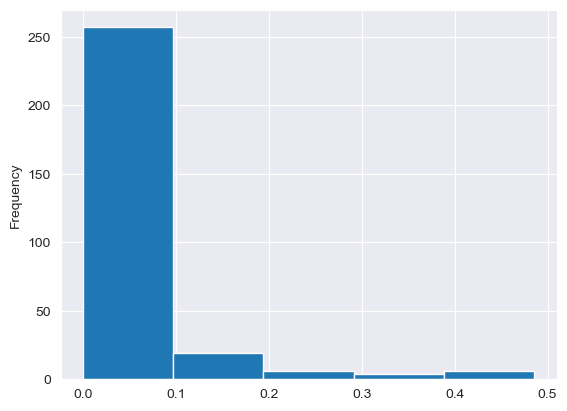

In [296]:
(train_set.isna().sum()/30471).plot(kind='hist', bins=5)

In [297]:
(train_set.isna().sum()/30471).mean()

0.03024445430485665

Удалим колонки, у которых более 35% значений пропущено

In [298]:
(train_set.isna().sum()/30471)[(train_set.isna().sum()/30471) > 0.35]

build_year                    0.446490
state                         0.444980
hospital_beds_raion           0.485445
cafe_sum_500_min_price_avg    0.449608
cafe_sum_500_max_price_avg    0.449608
cafe_avg_price_500            0.449608
dtype: float64

In [299]:
to_drop = (train_set.isna().sum()/30471)[(train_set.isna().sum()/30471) > 0.35].index.tolist()

In [300]:
train_set.drop(to_drop, axis=1, inplace=True)

In [301]:
train_set.shape

(30471, 286)

Имеются значения, которые коррелирую более чем с 30-ю признаками с коэффициентом более 0.95

<AxesSubplot:ylabel='Frequency'>

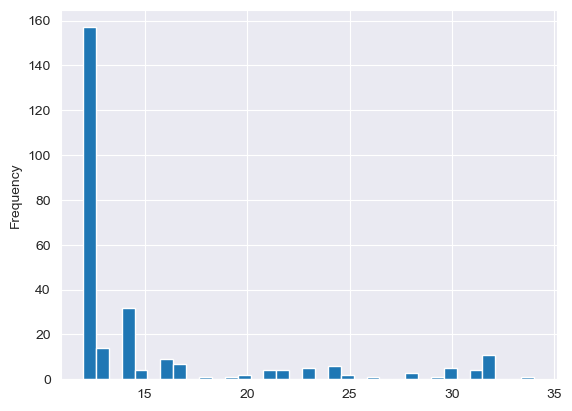

In [302]:
((correl[((correl >= 0.95) | (correl <= -0.95)) & (correl != 1)].isna().sum() - 286) * -1).plot(kind='hist', bins=35)

<AxesSubplot:>

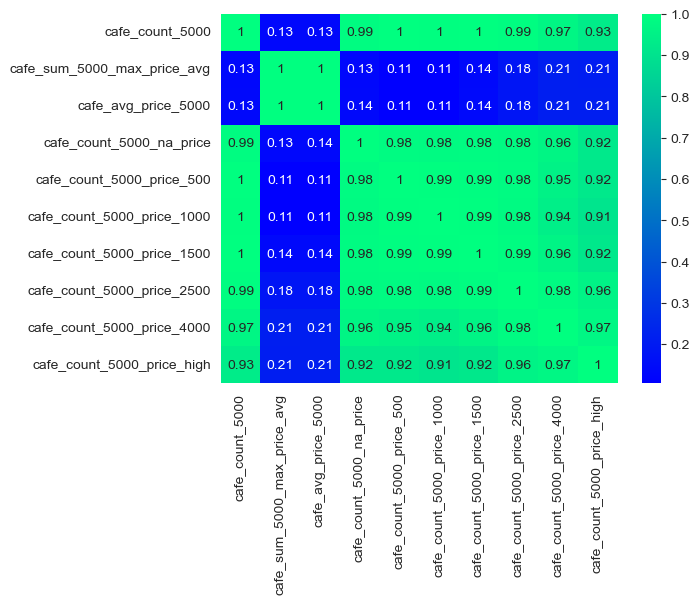

In [303]:
sns.heatmap(train_set[['cafe_count_5000',
         'cafe_sum_5000_max_price_avg',
         'cafe_avg_price_5000',
         'cafe_count_5000_na_price',
         'cafe_count_5000_price_500',
         'cafe_count_5000_price_1000',
         'cafe_count_5000_price_1500',
         'cafe_count_5000_price_2500',
         'cafe_count_5000_price_4000',
         'cafe_count_5000_price_high'
        ]].corr(), cmap='winter', annot=True)

<AxesSubplot:>

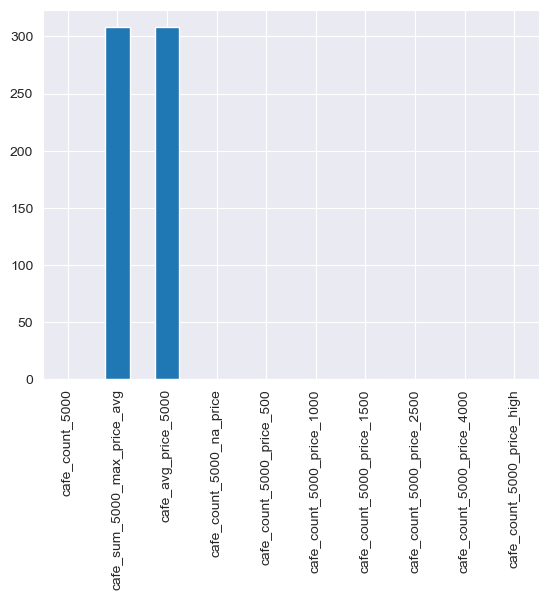

In [304]:
train_set[['cafe_count_5000',
         'cafe_sum_5000_max_price_avg',
         'cafe_avg_price_5000',
         'cafe_count_5000_na_price',
         'cafe_count_5000_price_500',
         'cafe_count_5000_price_1000',
         'cafe_count_5000_price_1500',
         'cafe_count_5000_price_2500',
         'cafe_count_5000_price_4000',
         'cafe_count_5000_price_high'
        ]].isna().sum().plot(kind='bar')

Как видно, между показателями боьшая корреляция. Низкая корреляция у 2-х параметров связана с наличием просроченных значений.
Достаточно оставить только один параметр. Оставляем cafe_count_5000

In [305]:
train_set.drop(['cafe_sum_5000_max_price_avg',
             'cafe_avg_price_5000',
             'cafe_count_5000_na_price',
             'cafe_count_5000_price_500',
             'cafe_count_5000_price_1000',
             'cafe_count_5000_price_1500',
             'cafe_count_5000_price_2500',
             'cafe_count_5000_price_4000',
             'cafe_count_5000_price_high'], axis=1, inplace=True)

<AxesSubplot:>

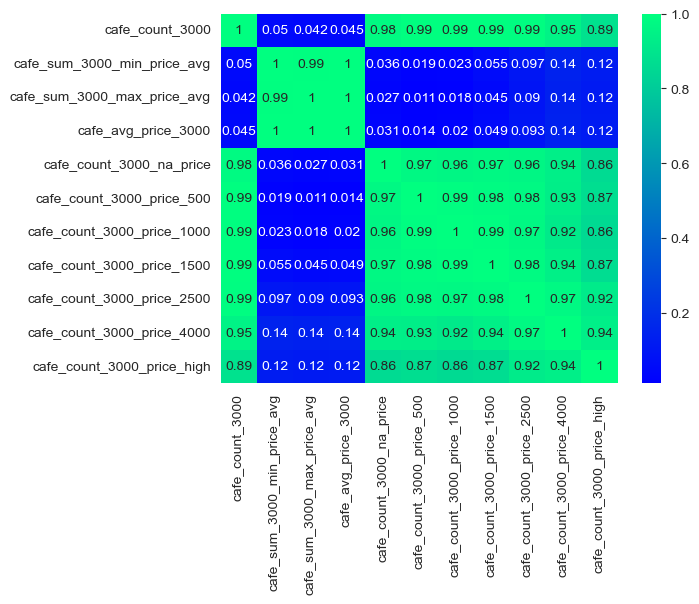

In [306]:
sns.heatmap(train_set[['cafe_count_3000',
 'cafe_sum_3000_min_price_avg',
 'cafe_sum_3000_max_price_avg',
 'cafe_avg_price_3000',
 'cafe_count_3000_na_price',
 'cafe_count_3000_price_500',
 'cafe_count_3000_price_1000',
 'cafe_count_3000_price_1500',
 'cafe_count_3000_price_2500',
 'cafe_count_3000_price_4000',
 'cafe_count_3000_price_high']].corr(), cmap='winter', annot=True)

<AxesSubplot:>

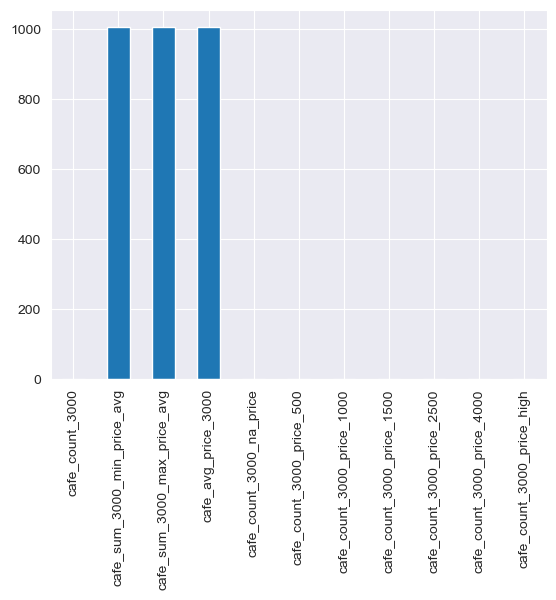

In [307]:
train_set[['cafe_count_3000',
         'cafe_sum_3000_min_price_avg',
         'cafe_sum_3000_max_price_avg',
         'cafe_avg_price_3000',
         'cafe_count_3000_na_price',
         'cafe_count_3000_price_500',
         'cafe_count_3000_price_1000',
         'cafe_count_3000_price_1500',
         'cafe_count_3000_price_2500',
         'cafe_count_3000_price_4000',
         'cafe_count_3000_price_high'
        ]].isna().sum().plot(kind='bar')

Аналогичная ситуация и с этой группой показателей. Оставляем 1 показатель, остальные удаляем

In [308]:
train_set.drop(['cafe_sum_3000_min_price_avg',
         'cafe_sum_3000_max_price_avg',
         'cafe_avg_price_3000',
         'cafe_count_3000_na_price',
         'cafe_count_3000_price_500',
         'cafe_count_3000_price_1000',
         'cafe_count_3000_price_1500',
         'cafe_count_3000_price_2500',
         'cafe_count_3000_price_4000',
         'cafe_count_3000_price_high'], axis=1, inplace=True)

<AxesSubplot:>

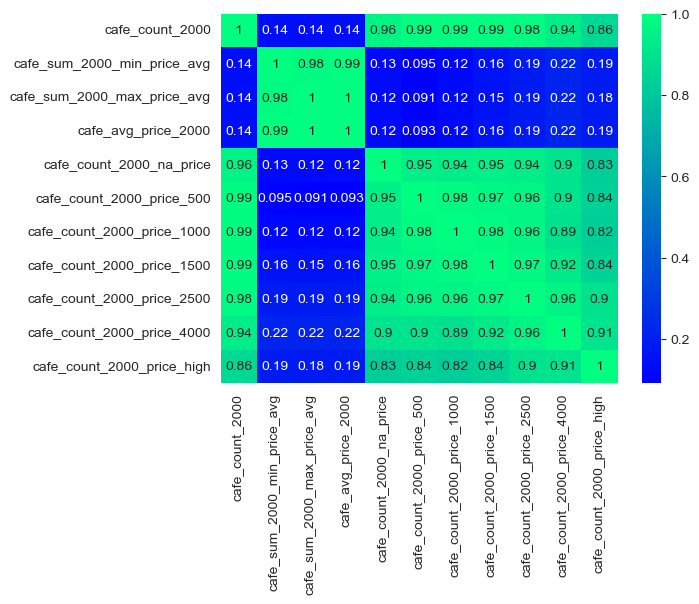

In [309]:
sns.heatmap(train_set[['cafe_count_2000',
                        'cafe_sum_2000_min_price_avg',
                        'cafe_sum_2000_max_price_avg',
                        'cafe_avg_price_2000',
                        'cafe_count_2000_na_price',
                        'cafe_count_2000_price_500',
                        'cafe_count_2000_price_1000',
                        'cafe_count_2000_price_1500',
                        'cafe_count_2000_price_2500',
                        'cafe_count_2000_price_4000',
                        'cafe_count_2000_price_high'
                    ]].corr(), cmap='winter', annot=True)

In [310]:
train_set.drop(['cafe_sum_2000_min_price_avg',
                 'cafe_sum_2000_max_price_avg',
                 'cafe_count_2000_na_price',
                 'cafe_count_2000_price_500',
                 'cafe_count_2000_price_1000',
                 'cafe_count_2000_price_1500',
                 'cafe_count_2000_price_2500',
                 'cafe_count_2000_price_4000',
                 'cafe_count_2000_price_high'], axis=1, inplace=True)

<AxesSubplot:>

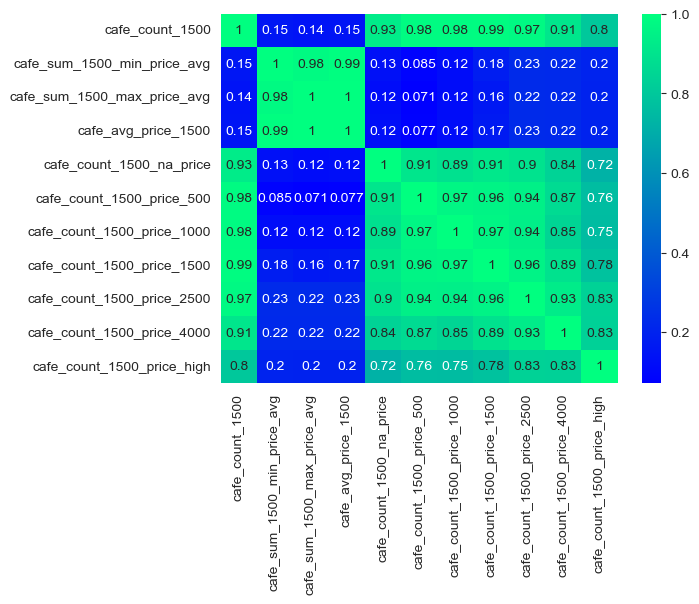

In [311]:
sns.heatmap(train_set[['cafe_count_1500',
                     'cafe_sum_1500_min_price_avg',
                     'cafe_sum_1500_max_price_avg',
                     'cafe_avg_price_1500',
                     'cafe_count_1500_na_price',
                     'cafe_count_1500_price_500',
                     'cafe_count_1500_price_1000',
                     'cafe_count_1500_price_1500',
                     'cafe_count_1500_price_2500',
                     'cafe_count_1500_price_4000',
                     'cafe_count_1500_price_high'
                    ]].corr(), cmap='winter', annot=True)

<AxesSubplot:>

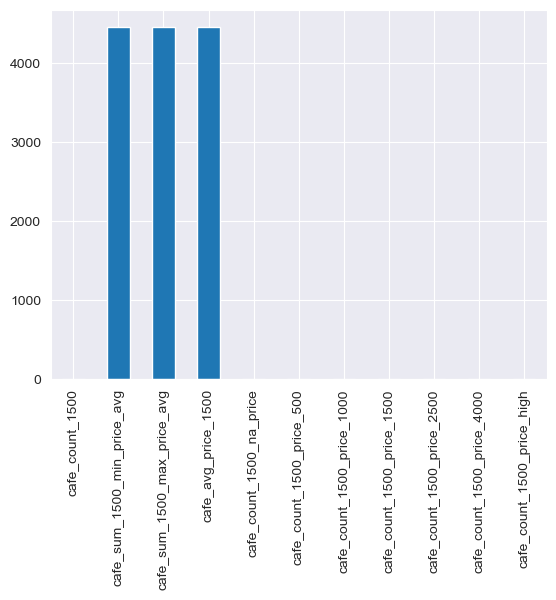

In [312]:
train_set[['cafe_count_1500',
             'cafe_sum_1500_min_price_avg',
             'cafe_sum_1500_max_price_avg',
             'cafe_avg_price_1500',
             'cafe_count_1500_na_price',
             'cafe_count_1500_price_500',
             'cafe_count_1500_price_1000',
             'cafe_count_1500_price_1500',
             'cafe_count_1500_price_2500',
             'cafe_count_1500_price_4000',
             'cafe_count_1500_price_high'
            ]].isna().sum().plot(kind='bar')

In [313]:
train_set.drop(['cafe_sum_1500_min_price_avg',
             'cafe_sum_1500_max_price_avg',
             'cafe_avg_price_1500',
             'cafe_count_1500_na_price',
             'cafe_count_1500_price_500',
             'cafe_count_1500_price_1000',
             'cafe_count_1500_price_1500',
             'cafe_count_1500_price_2500',
             'cafe_count_1500_price_4000',
             'cafe_count_1500_price_high'
            ], axis=1, inplace=True)

<AxesSubplot:>

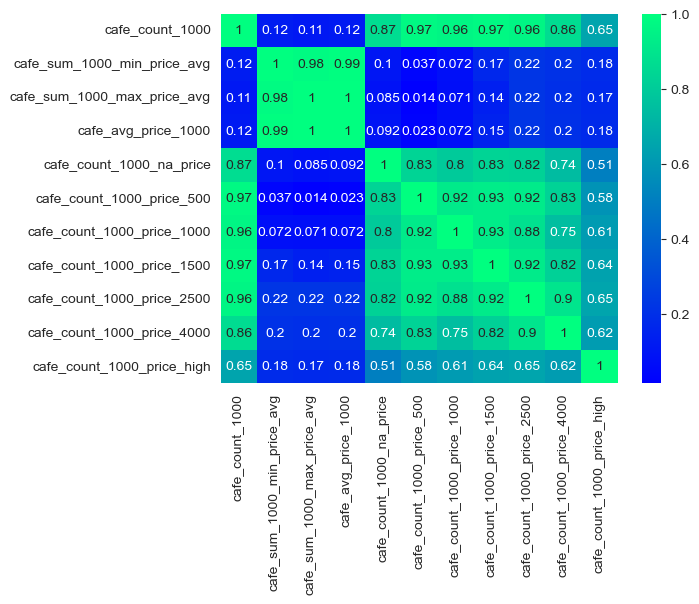

In [314]:
sns.heatmap(train_set[['cafe_count_1000',
                     'cafe_sum_1000_min_price_avg',
                     'cafe_sum_1000_max_price_avg',
                     'cafe_avg_price_1000',
                     'cafe_count_1000_na_price',
                     'cafe_count_1000_price_500',
                     'cafe_count_1000_price_1000',
                     'cafe_count_1000_price_1500',
                     'cafe_count_1000_price_2500',
                     'cafe_count_1000_price_4000',
                     'cafe_count_1000_price_high'
                    ]].corr(), cmap='winter', annot=True)

<AxesSubplot:>

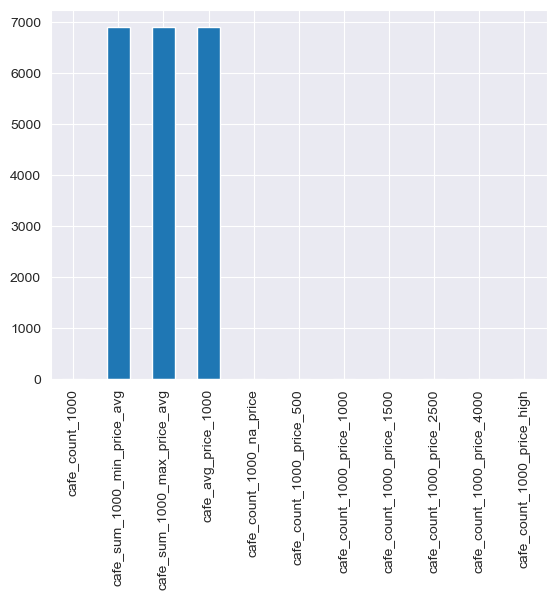

In [315]:
train_set[['cafe_count_1000',
         'cafe_sum_1000_min_price_avg',
         'cafe_sum_1000_max_price_avg',
         'cafe_avg_price_1000',
         'cafe_count_1000_na_price',
         'cafe_count_1000_price_500',
         'cafe_count_1000_price_1000',
         'cafe_count_1000_price_1500',
         'cafe_count_1000_price_2500',
         'cafe_count_1000_price_4000',
         'cafe_count_1000_price_high'
            ]].isna().sum().plot(kind='bar')

На этот раз оставляем 2 параметра: 'cafe_count_1000' и 'cafe_count_1000_price_high'

In [316]:
train_set.drop(['cafe_sum_1000_min_price_avg',
             'cafe_sum_1000_max_price_avg',
             'cafe_avg_price_1000',
             'cafe_count_1000_na_price',
             'cafe_count_1000_price_500',
             'cafe_count_1000_price_1000',
             'cafe_count_1000_price_1500',
             'cafe_count_1000_price_2500',
             'cafe_count_1000_price_4000'
            ], axis=1, inplace=True)

<AxesSubplot:>

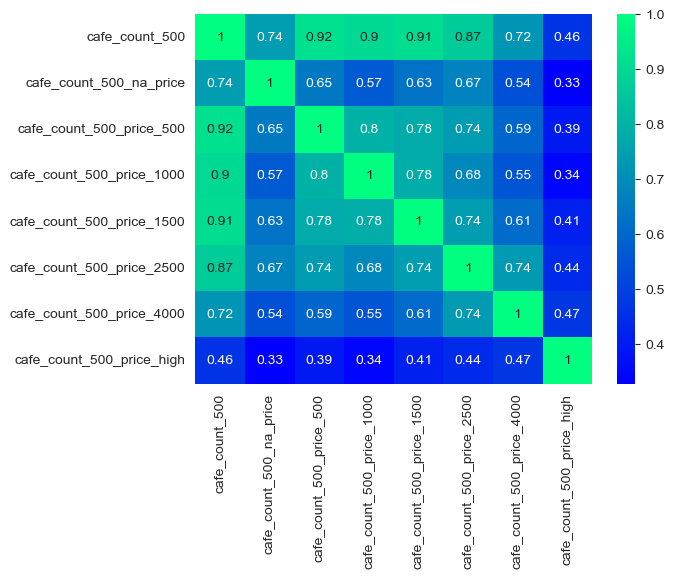

In [317]:
sns.heatmap(train_set[['cafe_count_500',
                         'cafe_count_500_na_price',
                         'cafe_count_500_price_500',
                         'cafe_count_500_price_1000',
                         'cafe_count_500_price_1500',
                         'cafe_count_500_price_2500',
                         'cafe_count_500_price_4000',
                         'cafe_count_500_price_high'
                    ]].corr(), cmap='winter', annot=True)

In [318]:
train_set[['cafe_count_500',
             'cafe_count_500_na_price',
             'cafe_count_500_price_500',
             'cafe_count_500_price_1000',
             'cafe_count_500_price_1500',
             'cafe_count_500_price_2500',
             'cafe_count_500_price_4000',
             'cafe_count_500_price_high'
            ]].isna().sum()

cafe_count_500               0
cafe_count_500_na_price      0
cafe_count_500_price_500     0
cafe_count_500_price_1000    0
cafe_count_500_price_1500    0
cafe_count_500_price_2500    0
cafe_count_500_price_4000    0
cafe_count_500_price_high    0
dtype: int64

В этом случае взаимосвязь, относительно предыдущих, не такая большая и нет пропущенных значений. Удалим только один показатель

In [319]:
train_set.drop(['cafe_count_500'
            ], axis=1, inplace=True)

In [320]:
train_set.shape

(30471, 238)

<AxesSubplot:>

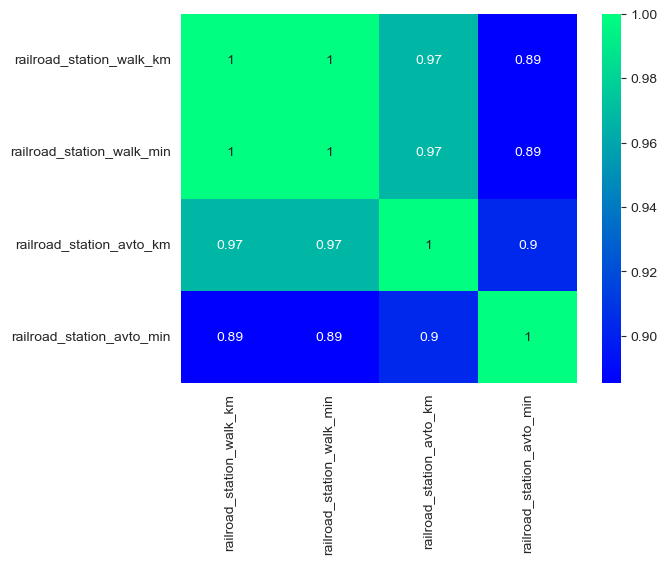

In [321]:
sns.heatmap(train_set[[
                     'railroad_station_walk_km',
                     'railroad_station_walk_min',
                     'railroad_station_avto_km',
                     'railroad_station_avto_min',
                        ]].corr(), cmap='winter', annot=True)

In [322]:
train_set[['railroad_station_walk_km',
          'railroad_station_walk_min',
          'railroad_station_avto_km',
          'railroad_station_avto_min'
         ]].isna().sum()

railroad_station_walk_km     25
railroad_station_walk_min    25
railroad_station_avto_km      0
railroad_station_avto_min     0
dtype: int64

<AxesSubplot:>

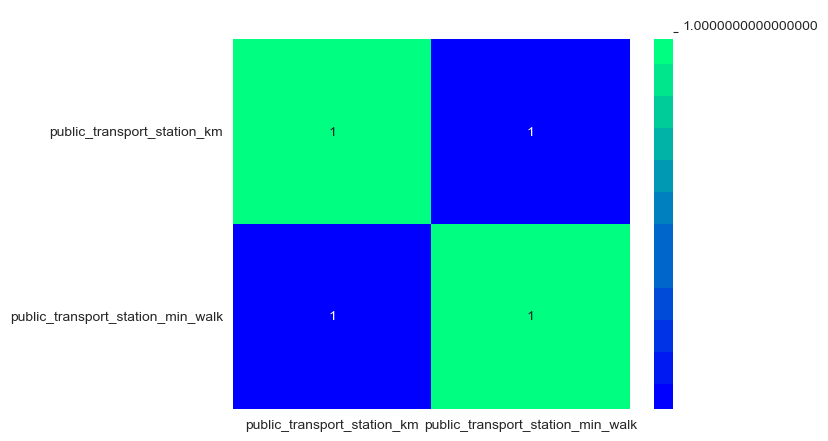

In [323]:
sns.heatmap(train_set[['public_transport_station_km',
                       'public_transport_station_min_walk'
                      ]].corr(), cmap='winter', annot=True)

In [324]:
train_set[['public_transport_station_km',
           'public_transport_station_min_walk'
            ]].isna().sum()

public_transport_station_km          0
public_transport_station_min_walk    0
dtype: int64

In [325]:
train_set.drop(['public_transport_station_km',
                'railroad_station_walk_min',
                'railroad_station_avto_min'
               ], axis=1, inplace=True)

In [326]:
train_set.shape

(30471, 235)

<AxesSubplot:>

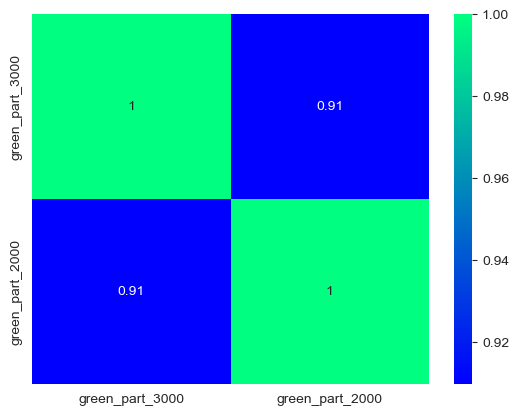

In [327]:

sns.heatmap(train_set[[
'green_part_3000',
'green_part_2000',
]].corr(), cmap='winter', annot=True)


<AxesSubplot:>

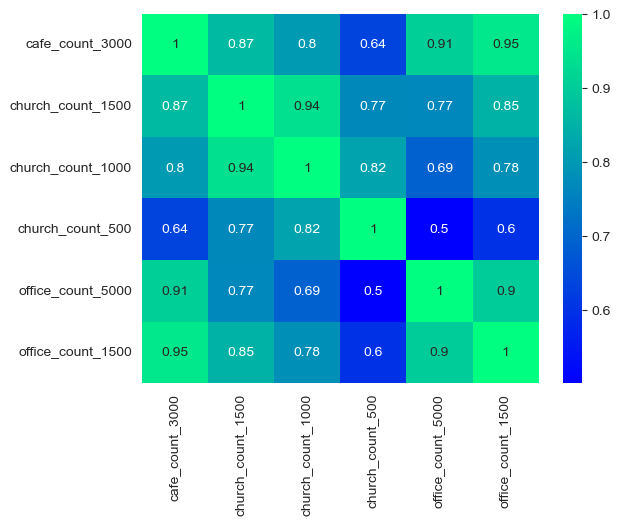

In [328]:
sns.heatmap(train_set[['cafe_count_3000',
'church_count_1500',
'church_count_1000',
'church_count_500',
'office_count_5000',
'office_count_1500']].corr(), cmap='winter', annot=True)

In [329]:
train_set[['cafe_count_3000',
            'church_count_1500',
            'church_count_1000',
            'church_count_500',
            'office_count_5000',
            'office_count_1500'
            ]].isna().sum()

cafe_count_3000      0
church_count_1500    0
church_count_1000    0
church_count_500     0
office_count_5000    0
office_count_1500    0
dtype: int64

In [330]:
train_set.drop(['church_count_1500',
                'office_count_1500'
               ], axis=1, inplace=True)

<AxesSubplot:>

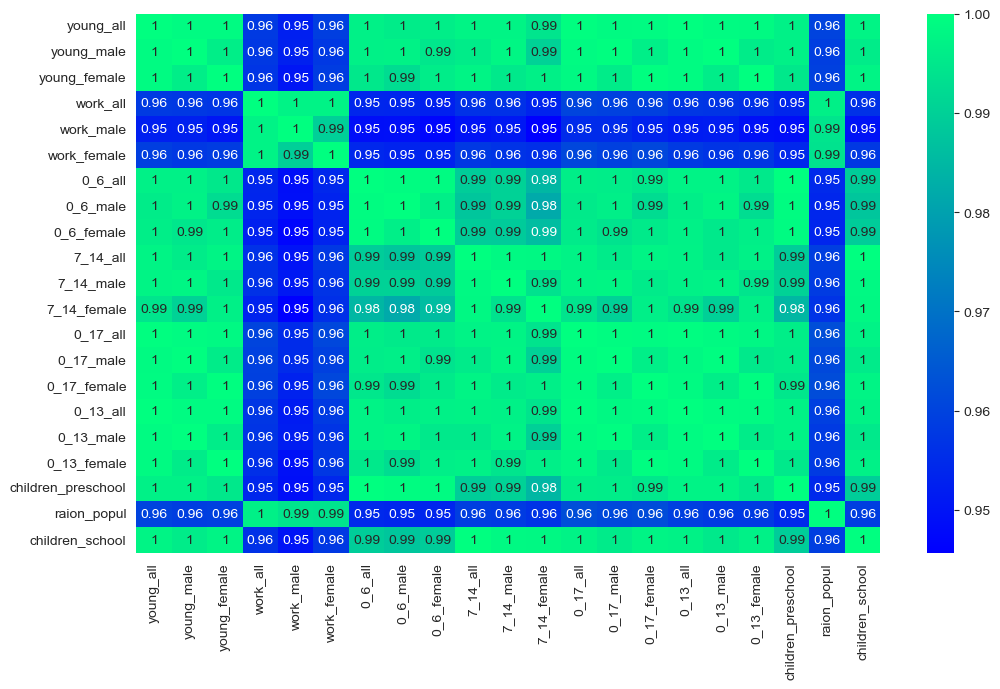

In [331]:
plt.figure(figsize=(12, 7))
sns.heatmap(train_set[[
                        'young_all',
                        'young_male',
                        'young_female',
                        'work_all',
                        'work_male',
                        'work_female',
                        '0_6_all',
                        '0_6_male',
                        '0_6_female',
                        '7_14_all',
                        '7_14_male',
                        '7_14_female',
                        '0_17_all',
                        '0_17_male',
                        '0_17_female',
                        '0_13_all',
                        '0_13_male',
                        '0_13_female',
                        'children_preschool',
                        'raion_popul',
                        'children_school'
                        ]].corr(), cmap='winter', annot=True)

In [332]:
train_set[[
             'young_all',
             'young_male',
             'young_female',
             'work_all',
             'work_male',
             'work_female',
             '0_6_all',
             '0_6_male',
             '0_6_female',
             '7_14_all',
             '7_14_male',
             '7_14_female',
             '0_17_all',
             '0_17_male',
             '0_17_female',
             '0_13_all',
             '0_13_male',
             '0_13_female',
            'children_preschool',
            'raion_popul'
            ]].isna().sum()

young_all             0
young_male            0
young_female          0
work_all              0
work_male             0
work_female           0
0_6_all               0
0_6_male              0
0_6_female            0
7_14_all              0
7_14_male             0
7_14_female           0
0_17_all              0
0_17_male             0
0_17_female           0
0_13_all              0
0_13_male             0
0_13_female           0
children_preschool    0
raion_popul           0
dtype: int64

<AxesSubplot:>

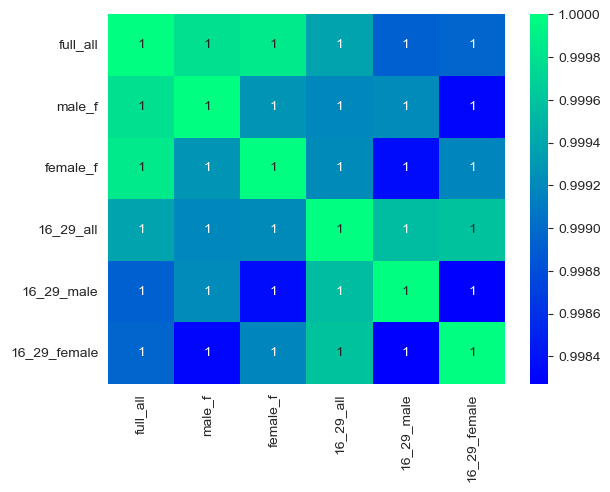

In [333]:
sns.heatmap(train_set[[
                        'full_all',
                        'male_f',
                        'female_f',
                        '16_29_all',
                        '16_29_male',
                        '16_29_female'
                        ]].corr(), cmap='winter', annot=True)

In [334]:
train_set[[
            'full_all',
            'male_f',
            'female_f',
             '16_29_all',
            '16_29_male',
            '16_29_female',
            ]].isna().sum()

full_all        0
male_f          0
female_f        0
16_29_all       0
16_29_male      0
16_29_female    0
dtype: int64

<AxesSubplot:>

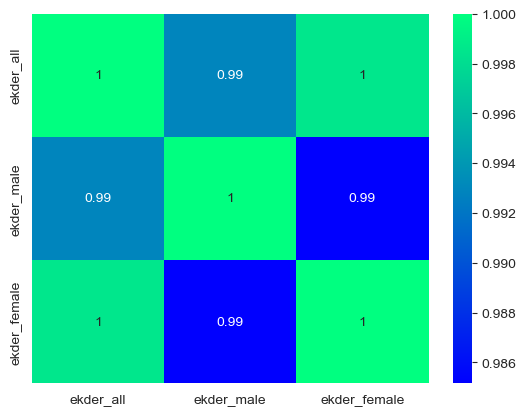

In [335]:
sns.heatmap(train_set[[
 'ekder_all',
 'ekder_male',
 'ekder_female',
]].corr(), cmap='winter', annot=True)

In [336]:
train_set[[
 'ekder_all',
 'ekder_male',
 'ekder_female',
]].isna().sum()

ekder_all       0
ekder_male      0
ekder_female    0
dtype: int64

In [337]:
train_set.drop(['young_all',
                'male_f',
                'female_f',
                '16_29_all',
                '16_29_male',
                '16_29_female',
                'young_male',
                'young_female',
                'work_all',
                'work_male',
                'work_female',
                '0_6_all',
                '0_6_male',
                '0_6_female',
                '7_14_all',
                '7_14_male',
                '7_14_female',
                '0_17_all',
                '0_17_male',
                '0_17_female',
                '0_13_all',
                '0_13_male',
                '0_13_female',
                'children_preschool',
                'ekder_male',
                'ekder_female',
                'children_school'
                ], axis=1, inplace=True)

In [338]:
train_set.shape

(30471, 206)

<AxesSubplot:>

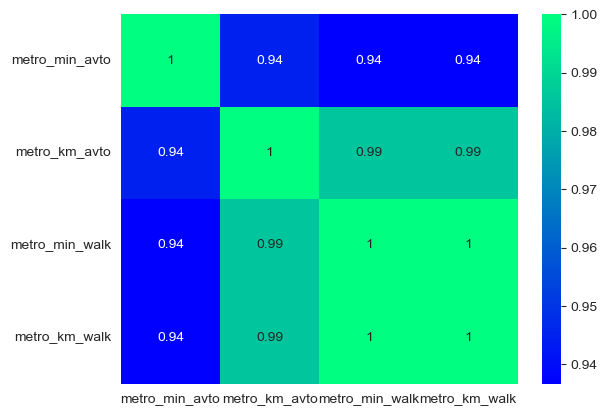

In [339]:
sns.heatmap(train_set[[
'metro_min_avto',
'metro_km_avto',
'metro_min_walk',
'metro_km_walk',
]].corr(), cmap='winter', annot=True)

In [340]:
train_set[[
'metro_min_avto',
'metro_km_avto',
'metro_min_walk',
'metro_km_walk',
]].isna().sum()

metro_min_avto     0
metro_km_avto      0
metro_min_walk    25
metro_km_walk     25
dtype: int64

<AxesSubplot:>

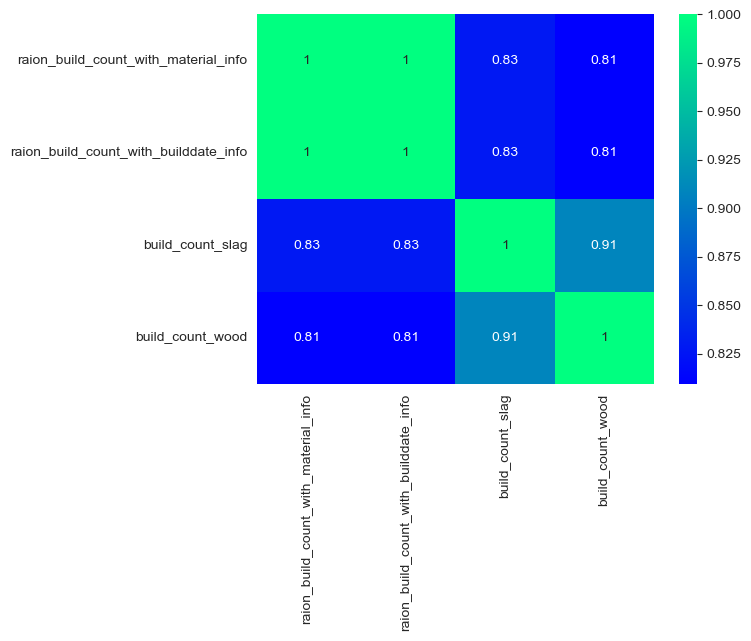

In [341]:
sns.heatmap(train_set[[
'raion_build_count_with_material_info',
'raion_build_count_with_builddate_info',
'build_count_slag',
'build_count_wood',
]].corr(), cmap='winter', annot=True)

In [342]:
train_set[[
'raion_build_count_with_material_info',
'raion_build_count_with_builddate_info',
]].isna().sum()

raion_build_count_with_material_info     5225
raion_build_count_with_builddate_info    5225
dtype: int64

In [343]:
train_set[['raion_build_count_with_material_info',
            'raion_build_count_with_builddate_info']].describe()

,raion_build_count_with_material_info,raion_build_count_with_builddate_info
count,25246.000000,25246.000000
mean,320.045274,319.723600
std,277.206357,277.248716
min,1.000000,1.000000
25%,177.000000,177.000000
50%,266.000000,266.000000
75%,374.000000,374.000000
max,1681.000000,1680.000000


<AxesSubplot:>

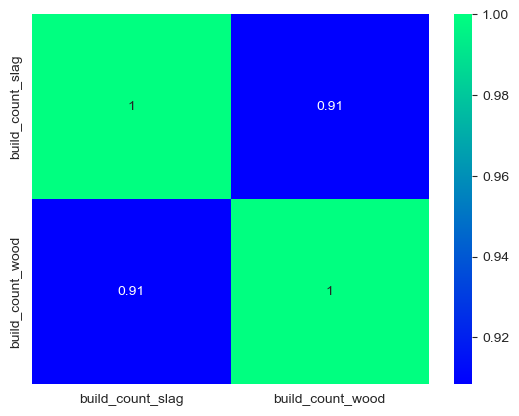

In [344]:
sns.heatmap(train_set[[
'build_count_slag',
'build_count_wood',
]].corr(), cmap='winter', annot=True)

In [345]:
train_set[[
'build_count_slag',
'build_count_wood',
]].isna().sum()

build_count_slag    5225
build_count_wood    5225
dtype: int64

<AxesSubplot:>

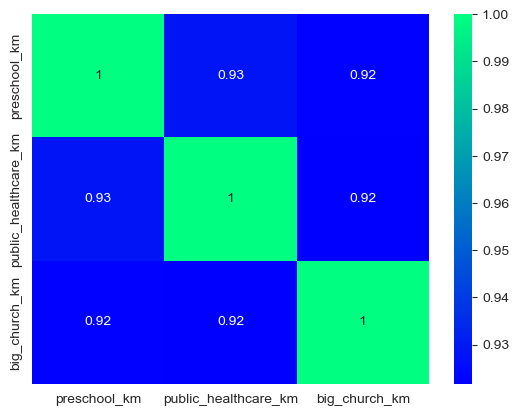

In [346]:
sns.heatmap(train_set[[
'preschool_km',
'public_healthcare_km',
'big_church_km'
]].corr(), cmap='winter', annot=True)

In [347]:
train_set[[
'preschool_km',
'public_healthcare_km',
'big_church_km'
]].describe()

,preschool_km,public_healthcare_km,big_church_km
count,30471.000000,30471.000000,30471.000000
mean,1.387957,3.431372,2.409296
std,3.127982,4.463901,3.048699
min,0.000000,0.000000,0.004072
25%,0.294659,1.273824,0.902914
50%,0.504465,2.324537,1.528353
75%,0.961723,4.048266,3.165201
max,47.394706,76.055135,45.669060


In [348]:
train_set[[
'preschool_km',
'public_healthcare_km',
'big_church_km'
]].isna().sum()

preschool_km            0
public_healthcare_km    0
big_church_km           0
dtype: int64

<AxesSubplot:>

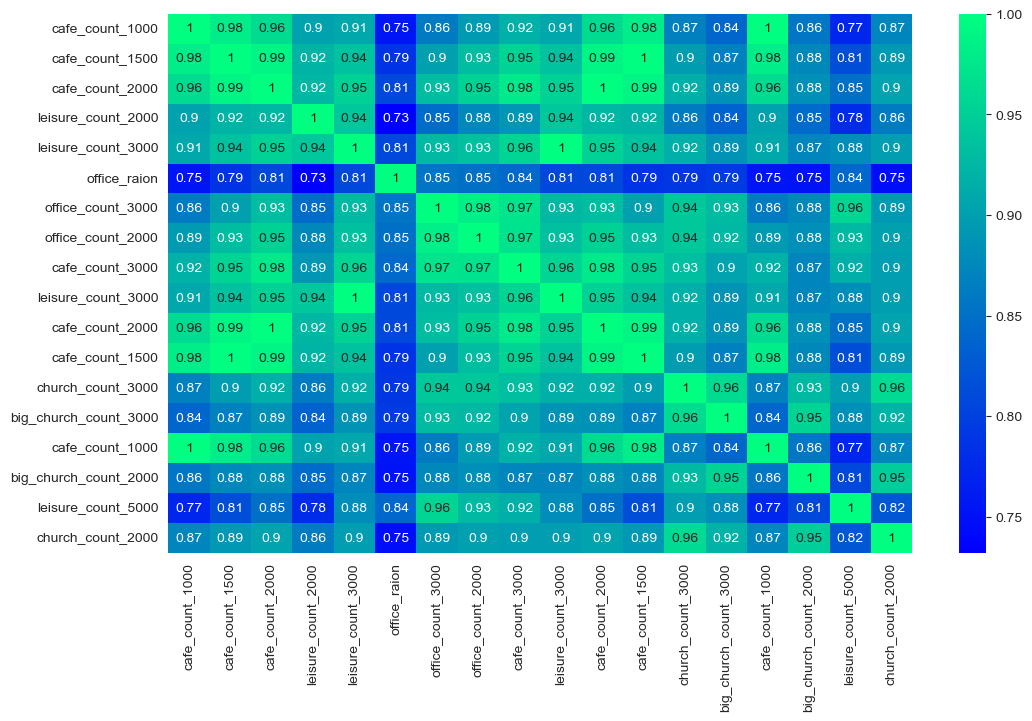

In [349]:
plt.figure(figsize=(12, 7))
sns.heatmap(train_set[['cafe_count_1000',
'cafe_count_1500',
'cafe_count_2000',
'leisure_count_2000',
'leisure_count_3000',
'office_raion',
'office_count_3000',
'office_count_2000',
'cafe_count_3000',
'leisure_count_3000',
'cafe_count_2000',
'cafe_count_1500',
'church_count_3000',
'big_church_count_3000',
'cafe_count_1000',
'big_church_count_2000',
'leisure_count_5000',
'church_count_2000']].corr(), cmap='winter', annot=True)

In [350]:
train_set[['cafe_count_1000',
'cafe_count_1500',
'cafe_count_2000',
'leisure_count_2000',
'leisure_count_3000',
'office_raion',
'office_count_3000',
'office_count_2000',
'cafe_count_3000',
'leisure_count_3000',
'cafe_count_2000',
'cafe_count_1500',
'church_count_3000',
'big_church_count_3000',
'cafe_count_1000',
'big_church_count_2000',
'leisure_count_5000',
'church_count_2000']].isna().sum()

cafe_count_1000          0
cafe_count_1500          0
cafe_count_2000          0
leisure_count_2000       0
leisure_count_3000       0
office_raion             0
office_count_3000        0
office_count_2000        0
cafe_count_3000          0
leisure_count_3000       0
cafe_count_2000          0
cafe_count_1500          0
church_count_3000        0
big_church_count_3000    0
cafe_count_1000          0
big_church_count_2000    0
leisure_count_5000       0
church_count_2000        0
dtype: int64

<AxesSubplot:>

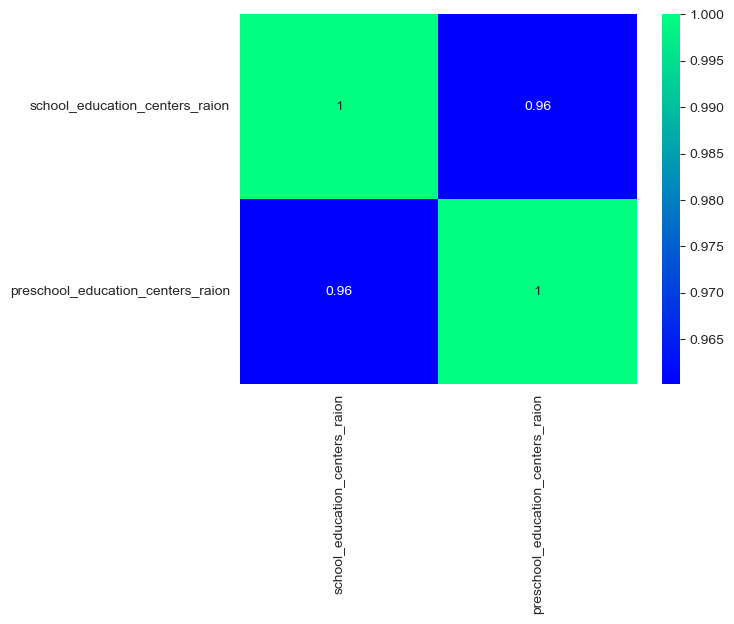

In [351]:
sns.heatmap(train_set[[
'school_education_centers_raion',
'preschool_education_centers_raion']].corr(), cmap='winter', annot=True)

In [352]:
train_set[[
'school_education_centers_raion',
'preschool_education_centers_raion']].isna().sum()

school_education_centers_raion       0
preschool_education_centers_raion    0
dtype: int64

In [353]:
train_set[['school_education_centers_raion',
            'preschool_education_centers_raion']].describe()

,school_education_centers_raion,preschool_education_centers_raion
count,30471.000000,30471.000000
mean,4.676446,4.035936
std,3.478874,3.026107
min,0.000000,0.000000
25%,2.000000,1.000000
50%,5.000000,4.000000
75%,7.000000,6.000000
max,14.000000,13.000000


<AxesSubplot:>

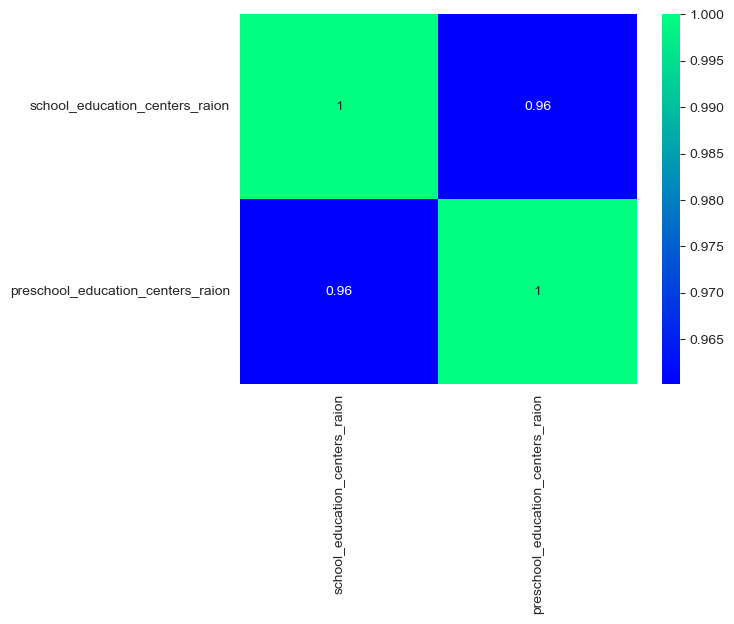

In [354]:
sns.heatmap(train_set[[
'school_education_centers_raion',
'preschool_education_centers_raion']].corr(), cmap='winter', annot=True)

In [355]:
train_set[[
'school_education_centers_raion',
'preschool_education_centers_raion']].isna().sum()

school_education_centers_raion       0
preschool_education_centers_raion    0
dtype: int64

<AxesSubplot:>

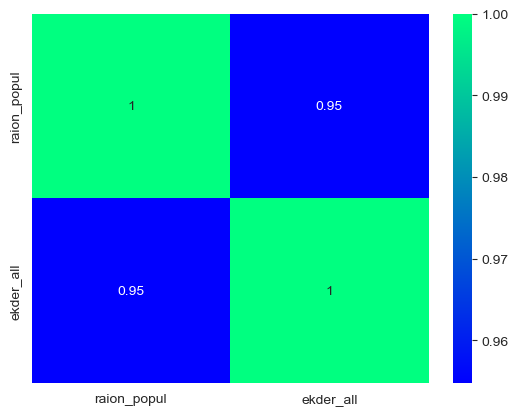

In [356]:
sns.heatmap(train_set[[
'raion_popul',
'ekder_all']].corr(), cmap='winter', annot=True)

In [357]:
train_set[['raion_popul',
'ekder_all']].isna().sum()

raion_popul    0
ekder_all      0
dtype: int64

<AxesSubplot:>

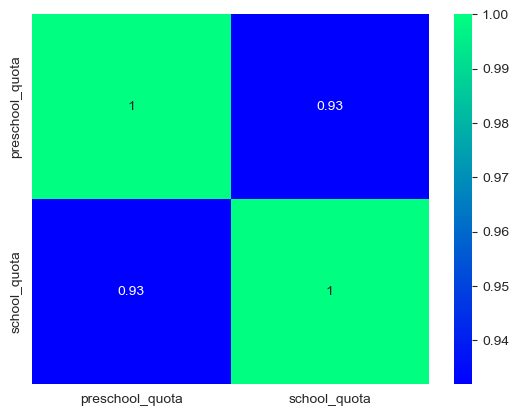

In [358]:
sns.heatmap(train_set[[
'preschool_quota',
'school_quota',]].corr(), cmap='winter', annot=True)

In [359]:
train_set[['preschool_quota',
'school_quota']].isna().sum()

preschool_quota    7000
school_quota       6997
dtype: int64

In [360]:
train_set[['preschool_quota', 'school_quota']].describe()

,preschool_quota,school_quota
count,23471.000000,23474.000000
mean,3302.084871,8358.671935
std,2176.620936,4315.983601
min,0.000000,1012.000000
25%,1926.000000,5782.000000
50%,2901.000000,7377.000000
75%,4116.000000,10027.000000
max,11926.000000,24750.000000


Разброс меньше в квоте на дет.сад. Оставляем эту колонку

Удаляем колонки

In [361]:
train_set.drop([
'preschool_km',
'public_healthcare_km',
'build_count_slag',
'raion_build_count_with_material_info',
'metro_min_avto',
'metro_min_walk',
'metro_km_walk',
'cafe_count_1000',
'cafe_count_1500',
'cafe_count_2000',
'leisure_count_2000',
'leisure_count_3000',
'preschool_education_centers_raion',
'office_count_3000',
'office_count_2000',
'cafe_count_3000',
'leisure_count_3000',
'cafe_count_2000',
'cafe_count_1500',
'church_count_3000',
'big_church_count_3000',
'cafe_count_1000',
'big_church_count_2000',
'ekder_all',
'school_education_centers_raion',
'school_quota',
'church_count_2000'], axis=1, inplace=True)

In [362]:
train_set.shape

(30471, 183)

In [363]:
train_set.columns.to_list()

['id',
 'timestamp',
 'full_sq',
 'life_sq',
 'floor',
 'max_floor',
 'material',
 'num_room',
 'kitch_sq',
 'product_type',
 'sub_area',
 'area_m',
 'raion_popul',
 'green_zone_part',
 'indust_part',
 'preschool_quota',
 'school_education_centers_top_20_raion',
 'healthcare_centers_raion',
 'university_top_20_raion',
 'sport_objects_raion',
 'additional_education_raion',
 'culture_objects_top_25',
 'culture_objects_top_25_raion',
 'shopping_centers_raion',
 'office_raion',
 'thermal_power_plant_raion',
 'incineration_raion',
 'oil_chemistry_raion',
 'radiation_raion',
 'railroad_terminal_raion',
 'big_market_raion',
 'nuclear_reactor_raion',
 'detention_facility_raion',
 'full_all',
 'build_count_block',
 'build_count_wood',
 'build_count_frame',
 'build_count_brick',
 'build_count_monolith',
 'build_count_panel',
 'build_count_foam',
 'build_count_mix',
 'raion_build_count_with_builddate_info',
 'build_count_before_1920',
 'build_count_1921-1945',
 'build_count_1946-1970',
 'build_co

In [364]:
train_set.drop(['id', 'price_doc'], axis=1).corr()

,full_sq,life_sq,floor,max_floor,material,num_room,kitch_sq,area_m,raion_popul,green_zone_part,...,trc_count_5000,trc_sqm_5000,cafe_count_5000,cafe_sum_5000_min_price_avg,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000
full_sq,1.000000,0.161112,0.089649,0.119225,0.032866,0.695444,0.020026,0.055334,-0.038257,0.031067,...,-0.006335,-0.012216,0.031134,0.046130,0.021293,0.023579,0.017534,0.025664,-0.006835,-0.044960
life_sq,0.161112,1.000000,0.045090,0.042442,0.011393,0.191024,0.000633,0.062274,-0.064386,0.039182,...,-0.033209,-0.032167,0.012082,0.053741,0.005537,0.005999,0.003248,0.011085,-0.025997,-0.055335
floor,0.089649,0.045090,1.000000,0.454488,-0.009043,-0.005657,-0.008457,-0.020031,-0.046788,-0.000984,...,-0.101256,-0.098870,-0.083942,0.024793,-0.085895,-0.087284,-0.025557,-0.086500,-0.132260,-0.133717
max_floor,0.119225,0.042442,0.454488,1.000000,0.045915,-0.014220,0.020345,-0.096464,-0.014906,0.008782,...,-0.092934,-0.085792,-0.085721,-0.043167,-0.087754,-0.087470,-0.074457,-0.089225,-0.127591,-0.119419
material,0.032866,0.011393,-0.009043,0.045915,1.000000,-0.026924,0.038747,-0.003117,-0.044522,0.015738,...,0.092925,0.087775,0.103882,0.099261,0.083229,0.091731,0.071795,0.091992,0.132811,0.089264
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
church_count_5000,0.023579,0.005999,-0.087284,-0.087470,0.091731,0.103297,0.015648,-0.216133,0.085164,-0.248318,...,0.782496,0.680912,0.966736,0.125158,0.979994,1.000000,0.456740,0.958993,0.817227,0.516070
mosque_count_5000,0.017534,0.003248,-0.025557,-0.074457,0.071795,0.076937,0.024242,-0.067047,0.017520,-0.247629,...,0.464397,0.459050,0.443906,0.134896,0.390070,0.456740,1.000000,0.385605,0.436713,0.196355
leisure_count_5000,0.025664,0.011085,-0.086500,-0.089225,0.091992,0.095442,0.012243,-0.197529,0.047223,-0.241719,...,0.697894,0.613347,0.974943,0.133108,0.948655,0.958993,0.385605,1.000000,0.762853,0.449808
sport_count_5000,-0.006835,-0.025997,-0.132260,-0.127591,0.132811,0.112950,0.033131,-0.430080,0.341907,-0.341044,...,0.908332,0.821635,0.828177,-0.032412,0.786452,0.817227,0.436713,0.762853,1.000000,0.739677


In [365]:
correl = train_set.drop(['id', 'price_doc'], axis=1).corr()
for i in correl:
    for j in correl[i]:
        if ((j >= 0.95) or (j <= -0.95)) and (j != 1):
            print(correl[correl[i] == j].index[0], i)

railroad_station_avto_km railroad_station_walk_km
railroad_station_walk_km railroad_station_avto_km
sadovoe_km ttk_km
bulvar_ring_km ttk_km
kremlin_km ttk_km
zd_vokzaly_avto_km ttk_km
ttk_km sadovoe_km
bulvar_ring_km sadovoe_km
kremlin_km sadovoe_km
zd_vokzaly_avto_km sadovoe_km
ttk_km bulvar_ring_km
sadovoe_km bulvar_ring_km
kremlin_km bulvar_ring_km
zd_vokzaly_avto_km bulvar_ring_km
ttk_km kremlin_km
sadovoe_km kremlin_km
bulvar_ring_km kremlin_km
zd_vokzaly_avto_km kremlin_km
ttk_km zd_vokzaly_avto_km
sadovoe_km zd_vokzaly_avto_km
bulvar_ring_km zd_vokzaly_avto_km
kremlin_km zd_vokzaly_avto_km
office_sqm_5000 office_count_5000
cafe_count_5000 office_count_5000
big_church_count_5000 office_count_5000
church_count_5000 office_count_5000
leisure_count_5000 office_count_5000
office_count_5000 office_sqm_5000
office_count_5000 cafe_count_5000
big_church_count_5000 cafe_count_5000
church_count_5000 cafe_count_5000
leisure_count_5000 cafe_count_5000
office_count_5000 big_church_count_5000


<AxesSubplot:>

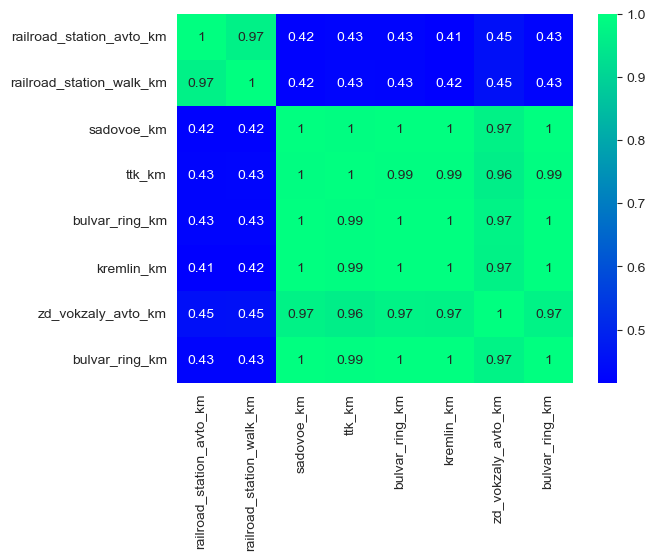

In [366]:
sns.heatmap(train_set[['railroad_station_avto_km', 'railroad_station_walk_km',
                        'sadovoe_km', 'ttk_km',
                        'bulvar_ring_km',
                        'kremlin_km',
                        'zd_vokzaly_avto_km',
                        'bulvar_ring_km']].corr(), cmap='winter', annot=True)

In [367]:
train_set[['railroad_station_avto_km', 'railroad_station_walk_km',
                        'sadovoe_km', 'ttk_km',
                        'bulvar_ring_km',
                        'kremlin_km',
                        'zd_vokzaly_avto_km',
                        'bulvar_ring_km']].describe()

,railroad_station_avto_km,railroad_station_walk_km,sadovoe_km,ttk_km,bulvar_ring_km,kremlin_km,zd_vokzaly_avto_km,bulvar_ring_km
count,30471.000000,30446.000000,30471.000000,30471.000000,30471.000000,30471.000000,30471.000000,30471.000000
mean,4.629722,4.430872,14.404332,11.574844,15.421303,16.467098,17.633199,15.421303
std,4.001399,3.900758,8.295672,8.115874,8.354132,8.268073,10.295889,8.354132
min,0.028153,0.028153,0.000355,0.001935,0.001947,0.072897,0.136715,0.001947
25%,2.097339,1.923495,8.635941,5.745974,9.570714,10.745504,10.365819,9.570714
50%,3.371933,3.213866,13.027037,10.120439,13.932463,15.126496,15.017417,13.932463
75%,5.539954,5.209439,18.728862,15.693586,19.945193,20.666814,24.061214,19.945193
max,24.653983,24.653041,68.853047,66.033200,69.984874,70.738769,91.215063,69.984874


In [368]:
train_set[['railroad_station_avto_km', 'railroad_station_walk_km',
                        'sadovoe_km', 'ttk_km',
                        'bulvar_ring_km',
                        'kremlin_km',
                        'zd_vokzaly_avto_km',
                        'bulvar_ring_km']].isna().sum()

railroad_station_avto_km     0
railroad_station_walk_km    25
sadovoe_km                   0
ttk_km                       0
bulvar_ring_km               0
kremlin_km                   0
zd_vokzaly_avto_km           0
bulvar_ring_km               0
dtype: int64

In [369]:
train_set.drop(['railroad_station_walk_km',
                'sadovoe_km', 'ttk_km',
                'bulvar_ring_km',
                'kremlin_km',
                'zd_vokzaly_avto_km',
                'bulvar_ring_km'], axis=1, inplace=True)

In [370]:
correl = train_set.drop(['id', 'price_doc'], axis=1).corr()
for i in correl:
    for j in correl[i]:
        if ((j >= 0.95) or (j <= -0.95)) and (j != 1):
            print(correl[correl[i] == j].index[0], i)

office_sqm_5000 office_count_5000
cafe_count_5000 office_count_5000
big_church_count_5000 office_count_5000
church_count_5000 office_count_5000
leisure_count_5000 office_count_5000
office_count_5000 office_sqm_5000
office_count_5000 cafe_count_5000
big_church_count_5000 cafe_count_5000
church_count_5000 cafe_count_5000
leisure_count_5000 cafe_count_5000
office_count_5000 big_church_count_5000
cafe_count_5000 big_church_count_5000
church_count_5000 big_church_count_5000
office_count_5000 church_count_5000
cafe_count_5000 church_count_5000
big_church_count_5000 church_count_5000
leisure_count_5000 church_count_5000
office_count_5000 leisure_count_5000
cafe_count_5000 leisure_count_5000
church_count_5000 leisure_count_5000


<AxesSubplot:>

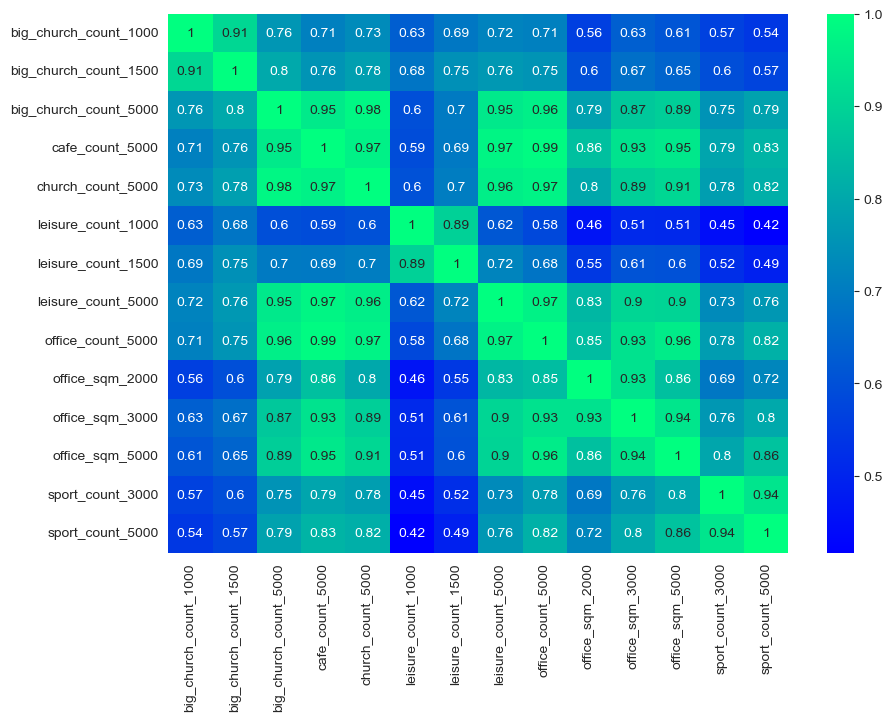

In [371]:
plt.figure(figsize=(10,7))
sns.heatmap(train_set[['big_church_count_1000',
                        'big_church_count_1500',
                        'big_church_count_5000',
                        'cafe_count_5000',
                        'church_count_5000',
                        'leisure_count_1000',
                        'leisure_count_1500',
                        'leisure_count_5000',
                        'office_count_5000',
                        'office_sqm_2000',
                        'office_sqm_3000',
                        'office_sqm_5000',
                        'sport_count_3000',
                        'sport_count_5000']].corr(), cmap='winter', annot=True)

<AxesSubplot:>

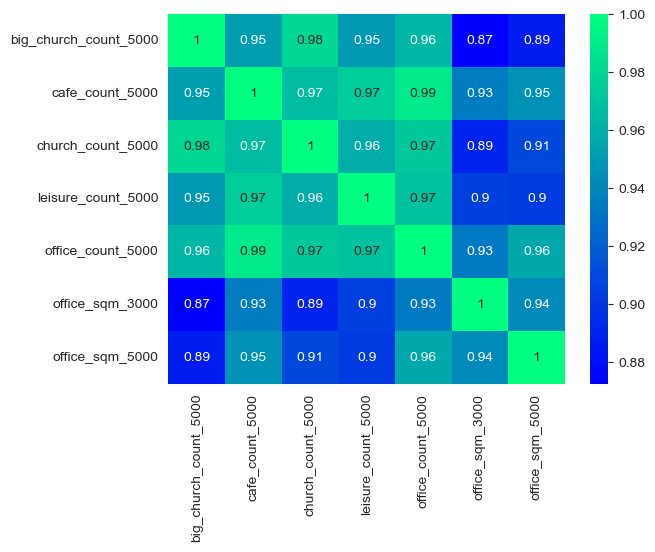

In [372]:
sns.heatmap(train_set[['big_church_count_5000',
                        'cafe_count_5000',
                        'church_count_5000',
                        'leisure_count_5000',
                        'office_count_5000',
                        'office_sqm_3000',
                        'office_sqm_5000']].corr(), cmap='winter', annot=True)

In [373]:
train_set[['big_church_count_5000',
            'cafe_count_5000',
            'church_count_5000',
            'leisure_count_5000',
            'office_count_5000',
            'office_sqm_3000',
            'office_sqm_5000']].isna().sum()

big_church_count_5000    0
cafe_count_5000          0
church_count_5000        0
leisure_count_5000       0
office_count_5000        0
office_sqm_3000          0
office_sqm_5000          0
dtype: int64

<AxesSubplot:>

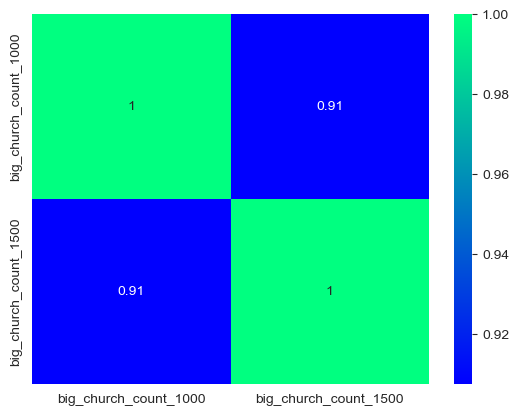

In [374]:
sns.heatmap(train_set[['big_church_count_1000',
                        'big_church_count_1500']].corr(), cmap='winter', annot=True)

In [375]:
train_set[['big_church_count_1000',
           'big_church_count_1500']].isna().sum()

big_church_count_1000    0
big_church_count_1500    0
dtype: int64

<AxesSubplot:>

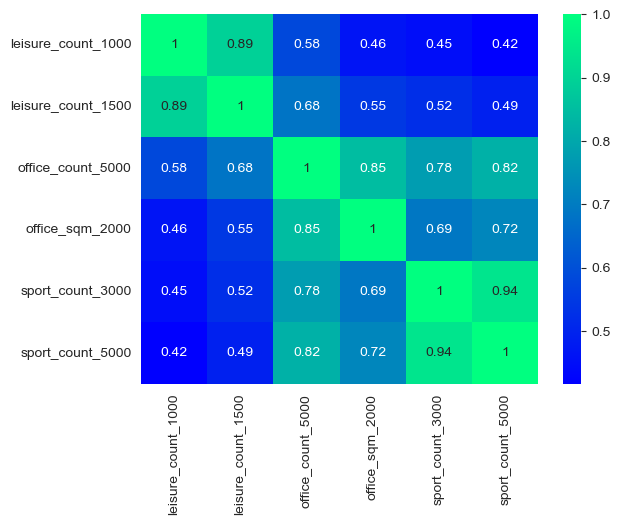

In [376]:
sns.heatmap(train_set[['leisure_count_1000',
                        'leisure_count_1500',
                        'office_count_5000',
                        'office_sqm_2000',
                        'sport_count_3000',
                        'sport_count_5000']].corr(), cmap='winter', annot=True)

In [377]:
train_set[['leisure_count_1000',
            'leisure_count_1500',
            'office_count_5000',
            'office_sqm_2000',
            'sport_count_3000',
            'sport_count_5000']].isna().sum()

leisure_count_1000    0
leisure_count_1500    0
office_count_5000     0
office_sqm_2000       0
sport_count_3000      0
sport_count_5000      0
dtype: int64

In [378]:
train_set.drop(['sport_count_5000',
                'big_church_count_1500',
                'leisure_count_1500',
                'big_church_count_5000',
                'cafe_count_5000',
                'church_count_5000',
                'leisure_count_5000',
                'office_count_5000',
                'office_sqm_5000',
                'office_sqm_2000'], axis=1, inplace=True)

In [379]:
correl = train_set.drop(['id', 'price_doc'], axis=1).corr()
features = []
for i in correl:
    for j in correl[i]:
        if ((j >= 0.9) or (j <= -0.9)) and (j != 1):
            features.append(i)
            features.append(correl[correl[i] == j].index[0])

In [380]:
sorted(list(set(features)))

['basketball_km',
 'big_church_km',
 'build_count_1921-1945',
 'build_count_wood',
 'exhibition_km',
 'green_part_1500',
 'green_part_2000',
 'green_part_3000',
 'metro_km_avto',
 'museum_km',
 'park_km',
 'power_transmission_line_km',
 'prom_part_1000',
 'prom_part_1500',
 'prom_part_2000',
 'radiation_km',
 'school_km',
 'shopping_centers_km',
 'sport_count_1500',
 'sport_count_2000',
 'sport_count_3000',
 'stadium_km',
 'swim_pool_km',
 'theater_km',
 'thermal_power_plant_km']

<AxesSubplot:>

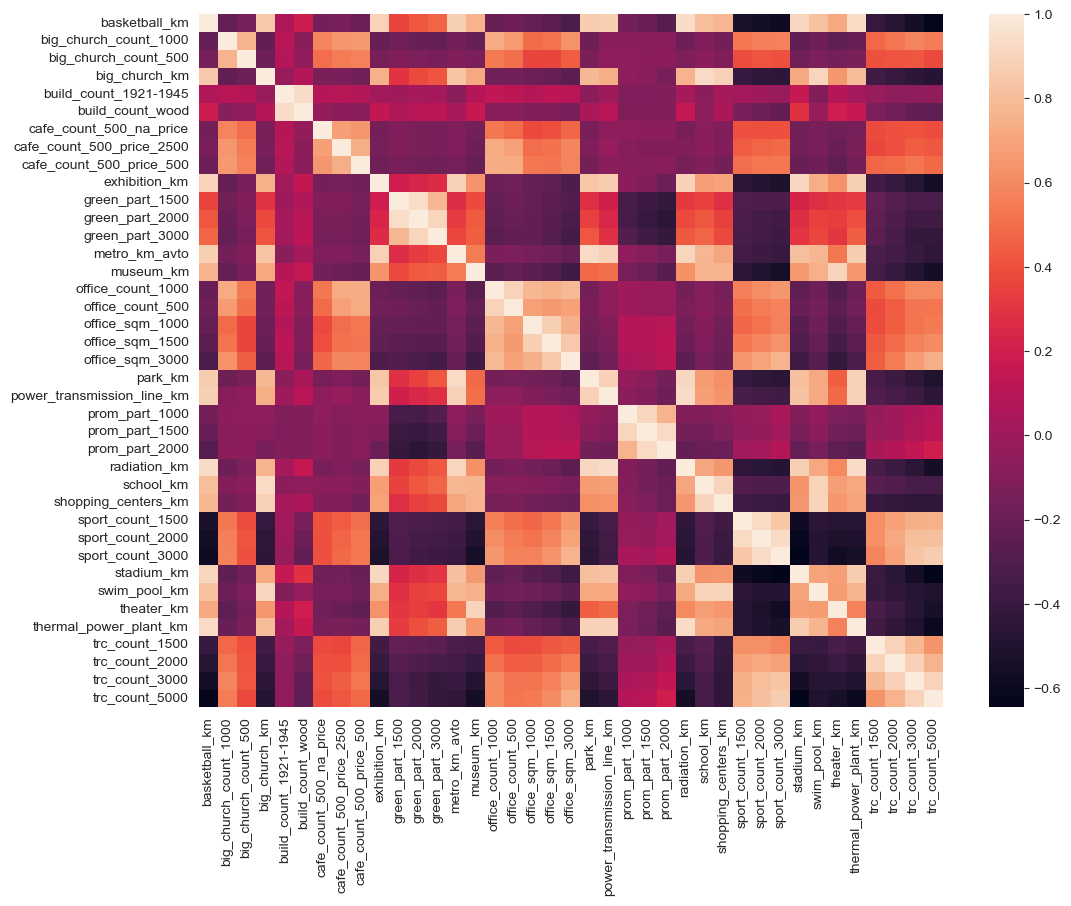

In [381]:
plt.figure(figsize=(12,9))
sns.heatmap(train_set[['basketball_km',
                     'big_church_count_1000',
                     'big_church_count_500',
                     'big_church_km',
                     'build_count_1921-1945',
                     'build_count_wood',
                     'cafe_count_500_na_price',
                     'cafe_count_500_price_2500',
                     'cafe_count_500_price_500',
                     'exhibition_km',
                     'green_part_1500',
                     'green_part_2000',
                     'green_part_3000',
                     'metro_km_avto',
                     'museum_km',
                     'office_count_1000',
                     'office_count_500',
                     'office_sqm_1000',
                     'office_sqm_1500',
                     'office_sqm_3000',
                     'park_km',
                     'power_transmission_line_km',
                     'prom_part_1000',
                     'prom_part_1500',
                     'prom_part_2000',
                     'radiation_km',
                     'school_km',
                     'shopping_centers_km',
                     'sport_count_1500',
                     'sport_count_2000',
                     'sport_count_3000',
                     'stadium_km',
                     'swim_pool_km',
                     'theater_km',
                     'thermal_power_plant_km',
                     'trc_count_1500',
                     'trc_count_2000',
                     'trc_count_3000',
                     'trc_count_5000']].corr())

In [382]:
train_set[['office_count_1000',
          'office_count_500',
          'office_sqm_1000',
          'office_sqm_1500',
          'office_sqm_3000']].isna().sum()

office_count_1000    0
office_count_500     0
office_sqm_1000      0
office_sqm_1500      0
office_sqm_3000      0
dtype: int64

In [383]:
train_set[['office_count_1000',
          'office_count_500',
          'office_sqm_1000',
          'office_sqm_1500',
          'office_sqm_3000']].describe()

,office_count_1000,office_count_500,office_sqm_1000,office_sqm_1500,office_sqm_3000
count,30471.000000,30471.000000,3.047100e+04,3.047100e+04,3.047100e+04
mean,2.248761,0.561649,5.078684e+04,1.183363e+05,4.528789e+05
std,6.599197,1.912596,1.200987e+05,2.613944e+05,8.603465e+05
min,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00
50%,0.000000,0.000000,0.000000e+00,1.130000e+04,1.173000e+05
75%,2.000000,0.000000,4.904300e+04,1.173000e+05,4.391730e+05
max,91.000000,34.000000,2.244723e+06,2.908344e+06,6.106112e+06


In [384]:
train_set[['trc_count_1500',
         'trc_count_2000',
         'trc_count_3000',
         'trc_count_5000']].isna().sum()

trc_count_1500    0
trc_count_2000    0
trc_count_3000    0
trc_count_5000    0
dtype: int64

In [385]:
train_set[['trc_count_1500',
         'trc_count_2000',
         'trc_count_3000',
         'trc_count_5000']].describe()

,trc_count_1500,trc_count_2000,trc_count_3000,trc_count_5000
count,30471.000000,30471.000000,30471.000000,30471.000000
mean,3.292048,5.381018,10.903876,28.463687
std,3.459457,5.127762,9.391254,22.159087
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,2.000000,5.000000
50%,2.000000,5.000000,10.000000,30.000000
75%,5.000000,9.000000,17.000000,42.000000
max,27.000000,37.000000,66.000000,120.000000


In [386]:
train_set[['sport_count_1500',
         'sport_count_2000',
         'sport_count_3000']].isna().sum()

sport_count_1500    0
sport_count_2000    0
sport_count_3000    0
dtype: int64

In [387]:
train_set[['sport_count_1500',
         'sport_count_2000',
         'sport_count_3000']].describe()

,sport_count_1500,sport_count_2000,sport_count_3000
count,30471.000000,30471.000000,30471.000000
mean,5.444816,9.130518,18.727708
std,5.181019,8.191902,16.601578
min,0.000000,0.000000,0.000000
25%,1.000000,2.000000,5.000000
50%,5.000000,8.000000,18.000000
75%,8.000000,14.000000,28.000000
max,37.000000,54.000000,100.000000


In [388]:
train_set.drop(['office_count_1000',
                'office_sqm_1000',
                'office_sqm_1500',
                'office_sqm_3000',
                'sport_count_2000',
                'sport_count_3000',
                'trc_count_3000',
                'trc_count_5000',
                'trc_count_2000'], axis=1, inplace=True)

In [389]:
train_set.shape

(30471, 158)

In [390]:
correl = train_set.drop(['id', 'price_doc'], axis=1).corr()
features = []
for i in correl:
    for j in correl[i]:
        if ((j >= 0.9) or (j <= -0.9)) and (j != 1):
            features.append(i)
            features.append(correl[correl[i] == j].index[0])
sorted(list(set(features)))

['basketball_km',
 'big_church_km',
 'build_count_1921-1945',
 'build_count_wood',
 'exhibition_km',
 'green_part_1500',
 'green_part_2000',
 'green_part_3000',
 'metro_km_avto',
 'museum_km',
 'park_km',
 'power_transmission_line_km',
 'prom_part_1000',
 'prom_part_1500',
 'prom_part_2000',
 'radiation_km',
 'school_km',
 'shopping_centers_km',
 'stadium_km',
 'swim_pool_km',
 'theater_km',
 'thermal_power_plant_km']

<AxesSubplot:>

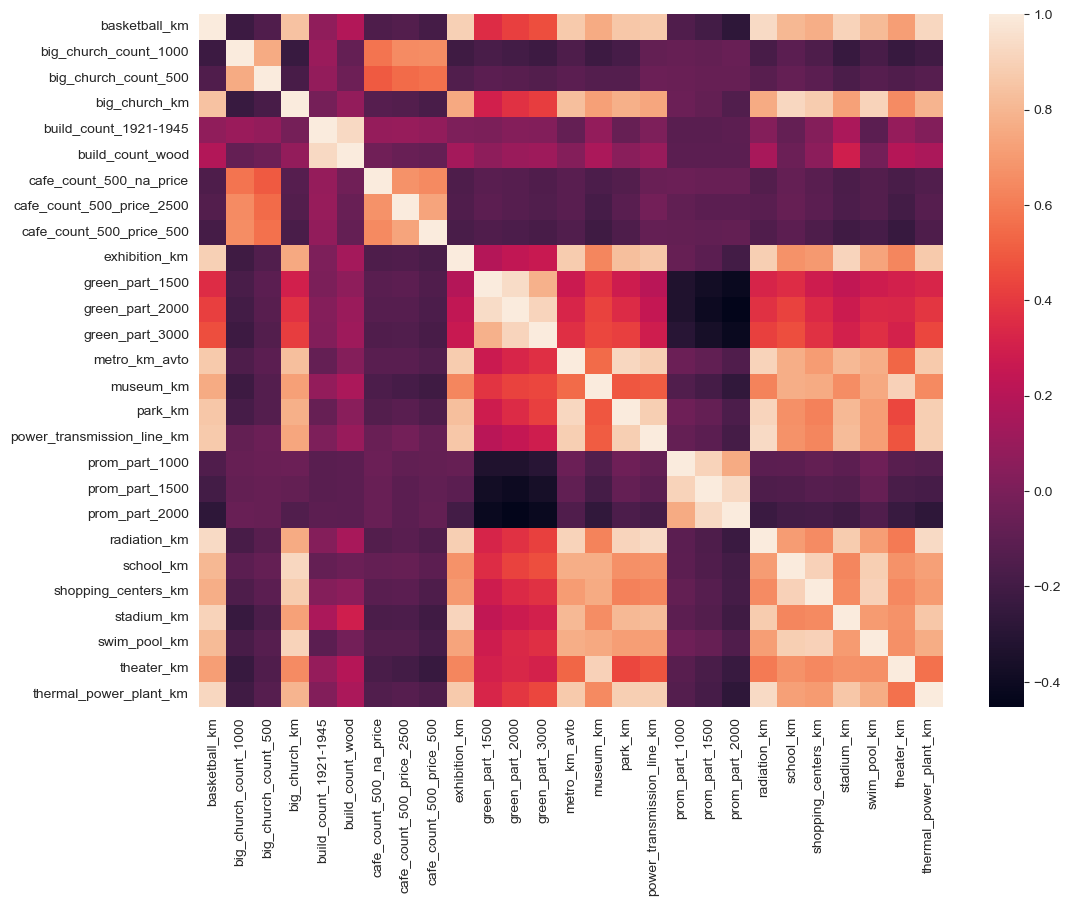

In [391]:
plt.figure(figsize=(12,9))
sns.heatmap(train_set[['basketball_km',
 'big_church_count_1000',
 'big_church_count_500',
 'big_church_km',
 'build_count_1921-1945',
 'build_count_wood',
 'cafe_count_500_na_price',
 'cafe_count_500_price_2500',
 'cafe_count_500_price_500',
 'exhibition_km',
 'green_part_1500',
 'green_part_2000',
 'green_part_3000',
 'metro_km_avto',
 'museum_km',
 'park_km',
 'power_transmission_line_km',
 'prom_part_1000',
 'prom_part_1500',
 'prom_part_2000',
 'radiation_km',
 'school_km',
 'shopping_centers_km',
 'stadium_km',
 'swim_pool_km',
 'theater_km',
 'thermal_power_plant_km']].corr())

In [392]:
train_set[['cafe_count_500_na_price',
 'cafe_count_500_price_2500',
 'cafe_count_500_price_500',
  'green_part_1500',
 'green_part_2000',
 'green_part_3000',
  'prom_part_1000',
 'prom_part_1500',
 'prom_part_2000']].describe()

,cafe_count_500_na_price,cafe_count_500_price_2500,cafe_count_500_price_500,green_part_1500,green_part_2000,green_part_3000,prom_part_1000,prom_part_1500,prom_part_2000
count,30471.000000,30471.000000,30471.000000,30471.000000,30471.000000,30471.000000,30471.000000,30471.000000,30471.000000
mean,0.181320,0.290900,0.654196,19.513918,21.183227,23.088453,9.005454,10.839026,11.434854
std,0.684711,1.116506,1.851203,14.278669,14.270052,14.093845,11.608203,11.027534,9.617029
min,0.000000,0.000000,0.000000,0.000000,0.010000,0.310000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,9.065000,10.580000,12.540000,0.000000,1.645000,3.440000
50%,0.000000,0.000000,0.000000,15.340000,18.130000,20.640000,4.100000,7.860000,9.230000
75%,0.000000,0.000000,1.000000,27.080000,28.810000,30.700000,13.160000,15.865000,16.500000
max,13.000000,22.000000,33.000000,90.410000,75.300000,74.020000,72.200000,63.000000,56.100000


In [393]:
train_set[['cafe_count_500_na_price',
 'cafe_count_500_price_2500',
 'cafe_count_500_price_500',
  'green_part_1500',
 'green_part_2000',
 'green_part_3000',
  'prom_part_1000',
 'prom_part_1500',
 'prom_part_2000']].isna().sum()

cafe_count_500_na_price      0
cafe_count_500_price_2500    0
cafe_count_500_price_500     0
green_part_1500              0
green_part_2000              0
green_part_3000              0
prom_part_1000               0
prom_part_1500               0
prom_part_2000               0
dtype: int64

In [394]:
train_set.drop(['cafe_count_500_price_2500',
'cafe_count_500_price_500',
'green_part_1500',
'green_part_2000',
'prom_part_1000',
'prom_part_1500'], axis=1, inplace=True)

In [395]:
train_set.shape

(30471, 152)

In [396]:
train_set.columns.tolist()

['id',
 'timestamp',
 'full_sq',
 'life_sq',
 'floor',
 'max_floor',
 'material',
 'num_room',
 'kitch_sq',
 'product_type',
 'sub_area',
 'area_m',
 'raion_popul',
 'green_zone_part',
 'indust_part',
 'preschool_quota',
 'school_education_centers_top_20_raion',
 'healthcare_centers_raion',
 'university_top_20_raion',
 'sport_objects_raion',
 'additional_education_raion',
 'culture_objects_top_25',
 'culture_objects_top_25_raion',
 'shopping_centers_raion',
 'office_raion',
 'thermal_power_plant_raion',
 'incineration_raion',
 'oil_chemistry_raion',
 'radiation_raion',
 'railroad_terminal_raion',
 'big_market_raion',
 'nuclear_reactor_raion',
 'detention_facility_raion',
 'full_all',
 'build_count_block',
 'build_count_wood',
 'build_count_frame',
 'build_count_brick',
 'build_count_monolith',
 'build_count_panel',
 'build_count_foam',
 'build_count_mix',
 'raion_build_count_with_builddate_info',
 'build_count_before_1920',
 'build_count_1921-1945',
 'build_count_1946-1970',
 'build_co

После выбора оптимального числа параметров попробуем обогатить нашу выборку новыми признаками

In [397]:
train_set.head()

,id,timestamp,full_sq,life_sq,floor,max_floor,material,num_room,kitch_sq,product_type,...,trc_sqm_3000,mosque_count_3000,market_count_3000,green_part_5000,prom_part_5000,trc_sqm_5000,cafe_sum_5000_min_price_avg,mosque_count_5000,market_count_5000,price_doc
0,1,2011-08-20,43,27.0,4.0,NaN,NaN,NaN,NaN,Investment,...,1419204,0,1,13.09,13.31,4036616,708.57,1,4,5850000
1,2,2011-08-23,34,19.0,3.0,NaN,NaN,NaN,NaN,Investment,...,491565,0,1,10.26,27.47,2034942,673.81,1,14,6000000
2,3,2011-08-27,43,29.0,2.0,NaN,NaN,NaN,NaN,Investment,...,52550,0,6,13.69,21.58,1572990,702.68,0,10,5700000
3,4,2011-09-01,89,50.0,9.0,NaN,NaN,NaN,NaN,Investment,...,205756,0,3,14.18,3.89,942180,931.58,0,3,13100000
4,5,2011-09-05,77,77.0,4.0,NaN,NaN,NaN,NaN,Investment,...,2296870,1,5,8.38,10.92,3503058,853.88,2,14,16331452


In [398]:
def square_repair(df):

    if 'price_doc' in df.columns:
        df = df.drop(df[(df.full_sq > 300) &
                        (df.price_doc < 15000000)]\
                       .index.tolist())

        df = df.drop(df[(df.full_sq == 0) & (df.life_sq == 0)]\
                       .index.tolist())

    # Определим коэффициент различия жилой и общей площади
    df.reset_index(drop=True, inplace=True)
    life_sq_coef = np.mean(df[(df.life_sq != 0) &
                              (df.full_sq != 0) &
                              (df.life_sq < df.full_sq)].life_sq /
                           df[(df.life_sq != 0) &
                              (df.full_sq != 0) &
                              (df.life_sq < df.full_sq)].full_sq)

    life_sq_to_change = df[(df.life_sq > df.full_sq) &
                           (df.full_sq > 20)].index.tolist()

    for i in life_sq_to_change:
        df.iloc[i, 3] = df.iloc[i].full_sq * life_sq_coef

    # Также преобразуем общую площадь, т.к. остались объекты с общей площадью < 20 кв. м и с большой жилой
    full_sq_to_change = df[df.life_sq > df.full_sq].index.tolist()

    for i in full_sq_to_change:
        df.iloc[i, 2] = df.iloc[i].life_sq / life_sq_coef

    indexes = df.life_sq[df.life_sq.isna()].index
    to_fill = df.life_sq[df.life_sq.isna()].copy()
    to_fill = df.full_sq[indexes] * life_sq_coef
    df.life_sq.fillna(to_fill, inplace=True)

    return df

In [399]:
def anomaly_dropper(df):
    if 'price_doc' in df.columns:
        fs_m = df.full_sq.mean()
        fs_std = df.full_sq.std()
        ls_m = df.life_sq.mean()
        ls_std = df.life_sq.std()

        df = df.drop(df[(df.full_sq > (fs_m + fs_std * 3)) |
                        (df.full_sq < (fs_m - fs_std * 3))
                        ].index.tolist()
                     )

        df = df.drop(df[(df.life_sq > (ls_m + ls_std * 3)) |
                        (df.life_sq < (ls_m - ls_std * 3))
                        ].index.tolist()
                     )
    return df

In [400]:
def year_repairer(df):

    if 'build_year' in df.columns:
        if df.build_year[(df.build_year > 1700) & (df.build_year < 2022)].any():

            mean_year = round(df.build_year[(df.build_year > 1700) &
                                            (df.build_year < 2022)].mean())

            df.build_year = df.build_year.fillna(mean_year)
            df.loc[~((df.build_year > 1700) &
                     (df.build_year < 2022)), 'build_year'] = mean_year

    return df

In [401]:
def na_replacer(df):
    mean_change = ['floor', 'max_floor', 'material', 'preschool_quota',
                   'raion_build_count_with_material_info',
                   'build_count_block', 'build_count_wood',
                   'preschool_quota', 'school_quota',
                   'raion_build_count_with_material_info',
                   'build_count_block', 'build_count_wood',
                   'build_count_frame', 'build_count_brick',
                   'build_count_monolith', 'build_count_panel',
                   'build_count_foam', 'build_count_slag',
                   'build_count_mix', 'raion_build_count_with_builddate_info',
                   'build_count_before_1920', 'build_count_1921-1945',
                   'build_count_1946-1970', 'build_count_1971-1995',
                   'build_count_after_1995', 'metro_min_walk',
                   'metro_km_walk', 'ID_railroad_station_walk',
                   'cafe_sum_500_max_price_avg', 'cafe_avg_price_500',
                   'cafe_sum_1000_max_price_avg', 'cafe_avg_price_1000',
                   'cafe_sum_1500_min_price_avg', 'cafe_sum_1500_max_price_avg',
                   'cafe_avg_price_1500', 'cafe_sum_2000_min_price_avg',
                   'cafe_sum_2000_max_price_avg', 'cafe_avg_price_2000', 'prom_part_5000']

    median_change = ['num_room', 'kitch_sq', 'state', 'school_quota',
                     'hospital_beds_raion', 'metro_min_walk', 'metro_km_walk',
                     'railroad_station_walk_km', 'railroad_station_walk_min',
                     'cafe_sum_500_min_price_avg', 'cafe_sum_1000_min_price_avg',
                     'cafe_sum_3000_min_price_avg', 'cafe_sum_3000_max_price_avg',
                     'cafe_avg_price_3000', 'cafe_sum_5000_min_price_avg',
                     'cafe_sum_5000_max_price_avg', 'cafe_avg_price_5000',
                     ]

    for i in mean_change:
        if i in df.columns:
            df[i].fillna(df[i].mean(), inplace=True)
    for i in median_change:
        if i in df.columns:
            df[i].fillna(df[i].median(), inplace=True)

    return df

In [402]:
def add_new_features(df):

    dop_info = df.groupby('sub_area', as_index=False).agg({'id': 'count',
                                   'full_sq': 'mean',
                                   'life_sq': 'mean',
                                   'max_floor': 'median',
                                   'num_room': 'median',
                                   'railroad_station_avto_km': 'mean',
                                   'area_m': 'median',
                                   'raion_popul': 'median',
                                   'build_count_after_1995': 'median',
                                   'build_count_before_1920': 'median',
                                   'build_count_1921-1945': 'median',
                                   'build_count_1946-1970': 'median',
                                   'build_count_1971-1995': 'median'
                                   })\
                    .rename(columns={'id': 'objects_total_sale',
                                     'full_sq': 'mean_full_sq_in_area',
                                     'life_sq': 'mean_life_sq_in_area',
                                     'max_floor': 'median_max_floor',
                                     'num_room': 'median_num_room',
                                     'railroad_station_avto_km': 'mean_distance_r_st_avto',
                                     'area_m': 'area_m_median',
                                     'raion_popul': 'raion_popul_median'})

    metro_count = df.groupby(['sub_area', 'ID_metro'], as_index=False)\
                        .agg({'id': 'count'})\
                        .groupby('sub_area', as_index=False).agg({'ID_metro': 'count'})\
                        .rename(columns={'ID_metro': 'metro_counts'})

    dop_info = dop_info.merge(metro_count, on='sub_area')

    dop_info['sq_per_citizen'] = dop_info.area_m_median / dop_info.raion_popul_median

    dop_info['metro_on_sq'] = dop_info.area_m_median / dop_info.metro_counts

    dop_info['citizen_on_1_station'] = dop_info.raion_popul_median / dop_info.metro_counts

    dop_info['new_build_ratio'] = dop_info.build_count_after_1995 / (
                                                                        dop_info.build_count_before_1920 +
                                                                        dop_info['build_count_1921-1945'] +
                                                                        dop_info['build_count_1946-1970'] +
                                                                        dop_info['build_count_1971-1995']
                                                                    )


    dop_info['old_build_ratio'] = (dop_info.build_count_before_1920 +
                                   dop_info['build_count_1921-1945']) / (
                                                                         dop_info['build_count_1946-1970'] +
                                                                         dop_info['build_count_1971-1995'] +
                                                                         dop_info.build_count_after_1995
                                                                        )

    dop_info['middle_build_ratio'] = (dop_info['build_count_1946-1970'] +
                                      dop_info['build_count_1971-1995']) / ( dop_info.build_count_before_1920 +
                                                                             dop_info['build_count_1921-1945'] +
                                                                             dop_info.build_count_after_1995
                                                                           )

    dop_info.drop(['area_m_median', 'raion_popul_median',
                   'build_count_before_1920', 'build_count_1921-1945',
                   'build_count_1946-1970', 'build_count_1971-1995',
                   'build_count_after_1995'], axis=1, inplace=True)

    df = df.merge(dop_info, on='sub_area')

    return df

In [403]:
def join_macro(df):
    df_with_macro = df.merge(time_macro, on='timestamp', how='left')

    df_with_macro['year'] = df_with_macro.timestamp.dt.year
    df_with_macro['month'] = df_with_macro.timestamp.dt.month
    df_with_macro['day'] = df_with_macro.timestamp.dt.day

    df_with_macro = df_with_macro.drop('timestamp', axis=1)
    df_with_macro = df_with_macro.drop('id', axis=1)

    for i in df_with_macro.columns:
        col_type = df_with_macro[i].dtype
        if col_type == 'object' or col_type.name == 'category':
            df_with_macro[i] = df_with_macro[i].astype('category')

    cat_features_new = [df_with_macro.columns.get_loc(col) for col in
                    df_with_macro.select_dtypes(include=['category']).columns]
    cat_features_new = [i for i in cat_features_new]

    print(cat_features_new)

    return df_with_macro

In [404]:
def yes_no_replacer(df):
    np.place(df, df == 'yes', 1)
    np.place(df, df == 'no', 0)
    return df

In [405]:
macro = pd.read_csv(os.path.join('data', 'macro.csv'), parse_dates=['timestamp'])

In [406]:
time_macro = macro.set_index('timestamp')

In [407]:
time_macro['modern_education_share'] = time_macro['modern_education_share'].str.replace(',', ".").astype(float)
time_macro.old_education_build_share = time_macro.old_education_build_share.str.replace(',', ".").astype(float)
time_macro.child_on_acc_pre_school = time_macro.child_on_acc_pre_school.str.replace(',', ".")
time_macro.child_on_acc_pre_school = time_macro.child_on_acc_pre_school.replace({'#!': np.nan})
time_macro.child_on_acc_pre_school = time_macro.child_on_acc_pre_school.astype(float)

In [408]:
np.mean(time_macro.isna().sum() / 2484)

0.19121569966980606

In [409]:
many_na = (time_macro.isna().sum() / 2484)[(time_macro.isna().sum() / 2484) > 0.3].index.tolist()

In [410]:
time_macro.drop(many_na, axis=1, inplace=True)

In [411]:
for i in time_macro:
    if time_macro[i].isna().sum() > 0:
        time_macro[i].fillna(time_macro[i].interpolate(method='time'), inplace=True)
for i in time_macro:
    if time_macro[i].isna().sum() > 0:
        time_macro[i].fillna(time_macro[i].interpolate(method='time', limit_direction='backward'), inplace=True)
time_macro = time_macro.reset_index()

In [412]:
sq_rep = FunctionTransformer(square_repair)
droper = FunctionTransformer(anomaly_dropper)
y_rep = FunctionTransformer(year_repairer)
na_repl = FunctionTransformer(na_replacer)
new_feat = FunctionTransformer(add_new_features)
join = FunctionTransformer(join_macro)
yes_no = FunctionTransformer(yes_no_replacer)

imp = SimpleImputer(strategy='most_frequent')

In [413]:
cat_model = CatBoostRegressor(n_estimators=1000,
                              max_depth=10,
                              learning_rate=0.01,
                              task_type="GPU",
                              cat_features=[7, 8, 19, 23,
                                            24, 25, 26, 27,
                                            28, 29, 30, 61,
                                            65, 69, 100],
                              leaf_estimation_iterations=2,
                              leaf_estimation_backtracking='Armijo',
                              grow_policy='SymmetricTree'
                              )
model2 = Pipeline(
    [
        ('sq_rep', sq_rep),
        ('droper', droper),
        ('y_rep', y_rep),
        ('na_repl', na_repl),
        ('new_feat', new_feat),
        ('join', join),
        ('imp', imp),
        ('yes_no', yes_no),
        ('model', cat_model)
    ]
)

In [415]:
y_train = new_feat.fit_transform(
                    na_repl.fit_transform(
                        y_rep.fit_transform(
                            droper.fit_transform(
                                sq_rep.fit_transform(
                                    train_set)
                                                )
                                            )
                                        )
                                    ).price_doc.copy()
log_y = np.log(y_train)

In [416]:
model2.fit(train_set, log_y)

[7, 8, 19, 23, 24, 25, 26, 27, 28, 29, 30, 61, 65, 69, 100]
price_doc deleted
0:	learn: 0.5813065	total: 179ms	remaining: 2m 58s
1:	learn: 0.5794683	total: 358ms	remaining: 2m 58s
2:	learn: 0.5776460	total: 536ms	remaining: 2m 58s
3:	learn: 0.5758169	total: 721ms	remaining: 2m 59s
4:	learn: 0.5740898	total: 903ms	remaining: 2m 59s
5:	learn: 0.5724047	total: 1.08s	remaining: 2m 59s
6:	learn: 0.5707652	total: 1.26s	remaining: 2m 59s
7:	learn: 0.5690681	total: 1.45s	remaining: 2m 59s
8:	learn: 0.5674505	total: 1.63s	remaining: 2m 59s
9:	learn: 0.5658349	total: 1.81s	remaining: 2m 58s
10:	learn: 0.5643017	total: 1.98s	remaining: 2m 58s
11:	learn: 0.5627644	total: 2.16s	remaining: 2m 58s
12:	learn: 0.5612049	total: 2.35s	remaining: 2m 58s
13:	learn: 0.5596767	total: 2.53s	remaining: 2m 58s
14:	learn: 0.5581642	total: 2.71s	remaining: 2m 57s
15:	learn: 0.5566933	total: 2.89s	remaining: 2m 58s
16:	learn: 0.5552705	total: 3.08s	remaining: 2m 58s
17:	learn: 0.5538480	total: 3.26s	remaining: 2m 

Pipeline(steps=[('sq_rep',
                 FunctionTransformer(func=<function square_repair at 0x0000025D5A5E7CA0>)),
                ('droper',
                 FunctionTransformer(func=<function anomaly_dropper at 0x0000025D5A5F0040>)),
                ('y_rep',
                 FunctionTransformer(func=<function year_repairer at 0x0000025D5A5F0280>)),
                ('na_repl',
                 FunctionTransformer(func=<function na_replacer at 0x0000025D5AA70F70>)),
                ('new_feat',
                 FunctionTransformer(func=<function add_new_features at 0x0000025D5AA7A3A0>)),
                ('join',
                 FunctionTransformer(func=<function join_macro at 0x0000025D5A5F0CA0>)),
                ('imp', SimpleImputer(strategy='most_frequent')),
                ('yes_no',
                 FunctionTransformer(func=<function yes_no_replacer at 0x0000025D5A5F41F0>)),
                ('model',
                 <catboost.core.CatBoostRegressor object at 0x0000025D550

In [417]:
pred_no_droper = model2.predict(test_set[train_set.columns].copy())


KeyError: "['price_doc'] not in index"

In [133]:
results = pd.concat([test_set.id, pd.Series(np.exp(pred_no_droper))], axis=1)
results.columns = ['id', 'price_doc']
results.to_csv('results_no_droper_df_nf.csv', index=False)